## **Sales Prediction for Walmart Stores**

Predicting future sales is crucial for strategic planning. In this project, we analyze how internal and external factors impact Walmart's Weekly Sales. 

**Scope:**
- Analyze data from 45 Walmart stores (2010-2012).
- Incorporate external factors: CPI, Unemployment Rate, and Fuel Prices.

**Approach:**
- Time series analysis.
- Identify top-performing stores.
- Utilize multiple linear regression for sales prediction.

![Walmart](https://appinventiv.com/wp-content/uploads/sites/1/2019/09/Walmart%E2%80%99s-Journey-in-the-Blockchain-Arena-1.png)

## <p style="background-color:white;font-family:newtimeroman;color:blue;font-size:170%;text-align:center;border-radius:20px 60px;">Let's dive in . . .</p>


### **Introduction**

In the retail industry and chain of stores, effective supply chain management (SCM) is crucial. It involves balancing supply and demand to achieve financial and service objectives. Understanding product demand allows better supply chain planning and cost savings.

![Supply Chain](https://miro.medium.com/max/600/1*ixQ_TdPP3RmPQcPUzSVCrA.jpeg)

### **Data**

There are 3 datasets:

**Stores:**
- Store: Store number (1–45).
- Type: Store types 'A', 'B', or 'C'.
- Size: Store size calculated by the number of products (34,000 to 210,000).

**Sales:**
- Date: Observation date.
- Weekly_Sales: Sales during the week.
- Store: Store number (1–45).
- Dept: Department (1–99).
- IsHoliday: Boolean for holiday week.

**Features:**
- Temperature: Weekly region temperature.
- Fuel_Price: Fuel price during the week.
- MarkDown1-5: Types and quantities of markdown.
- CPI: Consumer Price Index.
- Unemployment: Unemployment rate.

### **Plan of Action**

1. Perform EDA & Time Series analysis.
2. Build Regression Models for sales prediction.

**Models:**
1. Lasso Regressor
2. Random Forest Regressor
3. Gradient Boosting Regressor
4. Support Vector Regressor
5. Time Series Analysis

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Dataset Importing and Querying</p>

    We will load all 3 datasets and merge them  into one big dataset that gives whole data. 

### Note :

*Since here we are only predicting Store level sales we will group the dataframes such that Department level data gets eliminated and take the sum of department level sales to give the store level sales.*

In [317]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting #downloading data from the kaggle (make sure you have kaggle.json file downloaded at the correct place)

usage: kaggle [-h] [-v]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: data from the kaggle (make sure you have kaggle.json file downloaded at the correct place)


In [318]:
#!pip install -r requirements.txt

In [319]:
import warnings, numpy as np, scipy.stats as stats, seaborn as sns, matplotlib.pyplot as plt
import pandas as pd, sklearn.metrics, sqlite3
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb, catboost as cb, lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from datetime import timedelta

warnings.filterwarnings("ignore")
ss = StandardScaler()

In [320]:
!pip freeze > requirements.txt

#### Load and read data

In [321]:
walmart = pd.read_csv('train.csv')

walmart_feature = pd.read_csv('features.csv')

walmart_store = pd.read_csv('stores.csv')

In [322]:
walmart.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [323]:
walmart.shape

(421570, 5)



### <p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Group by Store</p> 

#### Since we are predicting the weekly sales for Store level, we are grouping the data in walmart dataset to avoid the department and take the sum of department sales to store level.

In [324]:
walmart_store_group=walmart.groupby(["Store","Date"])[["Weekly_Sales"]].sum()
walmart_store_group.reset_index(inplace=True)

In [325]:
walmart_store_group

Store        Date  Weekly_Sales
0         1  2010-02-05    1643690.90
1         1  2010-02-12    1641957.44
2         1  2010-02-19    1611968.17
3         1  2010-02-26    1409727.59
4         1  2010-03-05    1554806.68
...     ...         ...           ...
6430     45  2012-09-28     713173.95
6431     45  2012-10-05     733455.07
6432     45  2012-10-12     734464.36
6433     45  2012-10-19     718125.53
6434     45  2012-10-26     760281.43

[6435 rows x 3 columns]

**Merging all the datasets into one place for easier test and analysis.**

In [326]:
result = pd.merge(walmart_store_group, walmart_store, how='inner', on='Store')
data = pd.merge(result, walmart_feature, how='inner', on=['Store', 'Date'])

In [327]:
print(data.shape)

(6435, 15)


**Dataframe Walmart with 421570 rows has come down to 6435 rows by doing a group by and merge** 




# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:120%;text-align:center;border-radius:20px 60px;">Data Cleaning</p>

<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;">Now let's look through the data and do some basic data cleaning</p> 


In [328]:
data.head()

Store        Date  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0      1  2010-02-05    1643690.90    A  151315        42.31       2.572   
1      1  2010-02-12    1641957.44    A  151315        38.51       2.548   
2      1  2010-02-19    1611968.17    A  151315        39.93       2.514   
3      1  2010-02-26    1409727.59    A  151315        46.63       2.561   
4      1  2010-03-05    1554806.68    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday  
0         8.106      False  
1         8.106       True  
2         8.106      False  
3         8.106      False  
4         8.106      False

In [329]:
#let's encode the categorical column : IsHoliday

data['IsHoliday'] = data['IsHoliday'].apply(lambda x: 1 if x == True else 0)

In [330]:
# Want to check the date column is in object format or datetime

data.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday         int64
dtype: object

In [331]:
# Now converting "Date"  to date time
data["Date"]=pd.to_datetime(data.Date)

# Extracting details from date given. so that can be used for seasonal checks or grouping
data["Day"]=data.Date.dt.day
data["Month"]=data.Date.dt.month
data["Year"]=data.Date.dt.year

# Changing the Months value from numbers to real values like Jan, Feb to Dec
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])

In [332]:
# Lets look into the null values
data.isnull().sum()

Store              0
Date               0
Weekly_Sales       0
Type               0
Size               0
Temperature        0
Fuel_Price         0
MarkDown1       4155
MarkDown2       4798
MarkDown3       4389
MarkDown4       4470
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
Day                0
Month              0
Year               0
dtype: int64

**Wow!! Now that's huge. More Than 65% of value are missing in MarkDown values**

*We can impute sum values as of now for the missing  and will later decide  whether to use Markdown for modeling or should take some other approach for imputing or whether to discard MarkDowns completely*


In [333]:
#will create this column for later use
data['MarkdownsSum'] = data['MarkDown1'] + data['MarkDown2'] + data['MarkDown3'] + data['MarkDown4'] + data['MarkDown5'] 

In [334]:
data.fillna(0, inplace = True)

In [335]:
data.describe().T

count                 mean                  min  \
Store         6435.0                 23.0                  1.0   
Date            6435  2011-06-17 00:00:00  2010-02-05 00:00:00   
Weekly_Sales  6435.0       1046964.877562            209986.25   
Size          6435.0             130287.6              34875.0   
Temperature   6435.0            60.663782                -2.06   
Fuel_Price    6435.0             3.358607                2.472   
MarkDown1     6435.0          2429.019322                  0.0   
MarkDown2     6435.0            818.87281              -265.76   
MarkDown3     6435.0           429.184037                -29.1   
MarkDown4     6435.0          1008.870435                  0.0   
MarkDown5     6435.0          1581.806813                  0.0   
CPI           6435.0           171.578394              126.064   
Unemployment  6435.0             7.999151                3.879   
IsHoliday     6435.0              0.06993                  0.0   
Day           6435.0            15.678322                  1.0   
Year          6435.0          2010.965035               2010.0   
MarkdownsSum  6435.0          5072.321368                  0.0   

                              25%                  50%                  75%  \
Store                        12.0                 23.0                 34.0   
Date          2010-10-08 00:00:00  2011-06-17 00:00:00  2012-02-24 00:00:00   
Weekly_Sales           553350.105            960746.04           1420158.66   
Size                      70713.0             126512.0             202307.0   
Temperature                 47.46                62.67                74.94   
Fuel_Price                  2.933                3.445                3.735   
MarkDown1                     0.0                  0.0               2302.3   
MarkDown2                     0.0                  0.0                 0.09   
MarkDown3                     0.0                  0.0                3.705   
MarkDown4                     0.0                  0.0               314.32   
MarkDown5                     0.0                  0.0             1983.265   
CPI                       131.735           182.616521           212.743293   
Unemployment                6.891                7.874                8.622   
IsHoliday                     0.0                  0.0                  0.0   
Day                           8.0                 16.0                 23.0   
Year                       2010.0               2011.0               2012.0   
MarkdownsSum                  0.0                  0.0                  0.0   

                              max            std  
Store                        45.0      12.988182  
Date          2012-10-26 00:00:00            NaN  
Weekly_Sales           3818686.45  564366.622054  
Size                     219622.0   63117.022465  
Temperature                100.14      18.444933  
Fuel_Price                  4.468        0.45902  
MarkDown1                88646.76    5871.477726  
MarkDown2               104519.54    4879.257489  
MarkDown3               141630.61    5273.523172  
MarkDown4                67474.85    3753.943314  
MarkDown5               108519.28     4098.19854  
CPI                    227.232807      39.356712  
Unemployment               14.313       1.875885  
IsHoliday                     1.0       0.255049  
Day                          31.0        8.75578  
Year                       2012.0       0.797019  
MarkdownsSum            160510.61   13926.096015

In [336]:
#add a 'week' column to the dataset for further analysis
data['Week'] = data.Date.dt.isocalendar().week 

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">EDA</p>
![](https://visme.co/blog/wp-content/uploads/2016/04/Header-5.gif)

In [337]:
data.describe()

Store                 Date  Weekly_Sales           Size  \
count  6435.000000                 6435  6.435000e+03    6435.000000   
mean     23.000000  2011-06-17 00:00:00  1.046965e+06  130287.600000   
min       1.000000  2010-02-05 00:00:00  2.099862e+05   34875.000000   
25%      12.000000  2010-10-08 00:00:00  5.533501e+05   70713.000000   
50%      23.000000  2011-06-17 00:00:00  9.607460e+05  126512.000000   
75%      34.000000  2012-02-24 00:00:00  1.420159e+06  202307.000000   
max      45.000000  2012-10-26 00:00:00  3.818686e+06  219622.000000   
std      12.988182                  NaN  5.643666e+05   63117.022465   

       Temperature   Fuel_Price     MarkDown1      MarkDown2      MarkDown3  \
count  6435.000000  6435.000000   6435.000000    6435.000000    6435.000000   
mean     60.663782     3.358607   2429.019322     818.872810     429.184037   
min      -2.060000     2.472000      0.000000    -265.760000     -29.100000   
25%      47.460000     2.933000      0.000000       0.000000       0.000000   
50%      62.670000     3.445000      0.000000       0.000000       0.000000   
75%      74.940000     3.735000   2302.300000       0.090000       3.705000   
max     100.140000     4.468000  88646.760000  104519.540000  141630.610000   
std      18.444933     0.459020   5871.477726    4879.257489    5273.523172   

          MarkDown4      MarkDown5          CPI  Unemployment    IsHoliday  \
count   6435.000000    6435.000000  6435.000000   6435.000000  6435.000000   
mean    1008.870435    1581.806813   171.578394      7.999151     0.069930   
min        0.000000       0.000000   126.064000      3.879000     0.000000   
25%        0.000000       0.000000   131.735000      6.891000     0.000000   
50%        0.000000       0.000000   182.616521      7.874000     0.000000   
75%      314.320000    1983.265000   212.743293      8.622000     0.000000   
max    67474.850000  108519.280000   227.232807     14.313000     1.000000   
std     3753.943314    4098.198540    39.356712      1.875885     0.255049   

               Day         Year   MarkdownsSum       Week  
count  6435.000000  6435.000000    6435.000000     6435.0  
mean     15.678322  2010.965035    5072.321368  25.818182  
min       1.000000  2010.000000       0.000000        1.0  
25%       8.000000  2010.000000       0.000000       14.0  
50%      16.000000  2011.000000       0.000000       26.0  
75%      23.000000  2012.000000       0.000000       38.0  
max      31.000000  2012.000000  160510.610000       52.0  
std       8.755780     0.797019   13926.096015  14.129201

In [338]:
data["Week"] = data["Week"].astype('int64')

data.dtypes

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Type                    object
Size                     int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                int64
Day                      int32
Month                   object
Year                     int32
MarkdownsSum           float64
Week                     int64
dtype: object

In [339]:
# List of columns to exclude from sum aggregation
exclude_columns = ['Date']  # Add the names of datetime columns

# Select only the numerical columns for aggregation
numerical_columns = data.select_dtypes(include=[np.number]).columns.difference(exclude_columns)

# Group by 'Week' and sum the numerical columns
df_weeks = data.groupby('Week')[numerical_columns].sum()

import plotly.express as px
fig = px.line( data_frame = df_weeks, x = df_weeks.index, y = 'Weekly_Sales', labels = {'Weekly_Sales' : 'Weekly Sales', 'x' : 'Weeks' }, title = 'Sales over weeks')
fig.update_traces(line_color='deeppink', line_width=3)

In [340]:
df_weeks.head()

CPI   Day  Fuel_Price  IsHoliday   MarkDown1  MarkDown2  \
Week                                                                     
1     15421.135275   585     287.489          0   214551.50  956964.10   
2     15430.151991  1215     291.404          0   148560.51  420168.49   
3     15443.190027  1845     293.341          0   104001.81  141268.63   
4     15456.228061  2475     294.581          0    63331.86   74200.84   
5     23017.155918   540     418.696          0  1624211.71  126542.47   

      MarkDown3   MarkDown4  MarkDown5  MarkdownsSum      Size  Store  \
Week                                                                    
1       5105.11    44069.57  223036.75    1425400.48  11725884   2070   
2       3172.06    22332.89  165721.27     678639.13  11725884   2070   
3       3098.39    27717.05  122143.56     352638.95  11725884   2070   
4       3089.75     4254.13  116290.60     177796.30  11725884   2070   
5       6408.63  1286593.08  267767.25    3307308.21  17588826   3105   

      Temperature  Unemployment  Week  Weekly_Sales    Year  
Week                                                         
1         3438.27       710.979    90  8.773121e+07  181035  
2         3167.09       710.979   180  8.269676e+07  181035  
3         3476.88       710.979   270  8.273564e+07  181035  
4         3455.57       710.979   360  7.943483e+07  181035  
5         4919.52      1098.848   675  1.419895e+08  271485

In [341]:
import plotly.graph_objs as go
from plotly import tools

fig = go.Figure()

#fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['Weekly_Sales'], name = 'Weekly Sales', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown1'], name = 'MarkDown1', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown2'], name = 'MarkDown2', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown3'], name = 'MarkDown3', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown4'], name = 'MarkDown4', mode = 'lines') )
fig.add_trace(go.Scatter( x = df_weeks.index, y = df_weeks['MarkDown5'], name = 'MarkDown5', mode = 'lines') )

fig.update_layout(title = 'Sales vs Markdown', xaxis_title = 'Weeks')

In [342]:
## setting all missing values in markdown columns to -500 for now. We will treat them later while performing Feature scaling
data['MarkDown1'].fillna(-500, inplace=True)
data['MarkDown2'].fillna(-500, inplace=True)
data['MarkDown3'].fillna(-500, inplace=True)
data['MarkDown4'].fillna(-500, inplace=True)
data['MarkDown5'].fillna(-500, inplace=True)

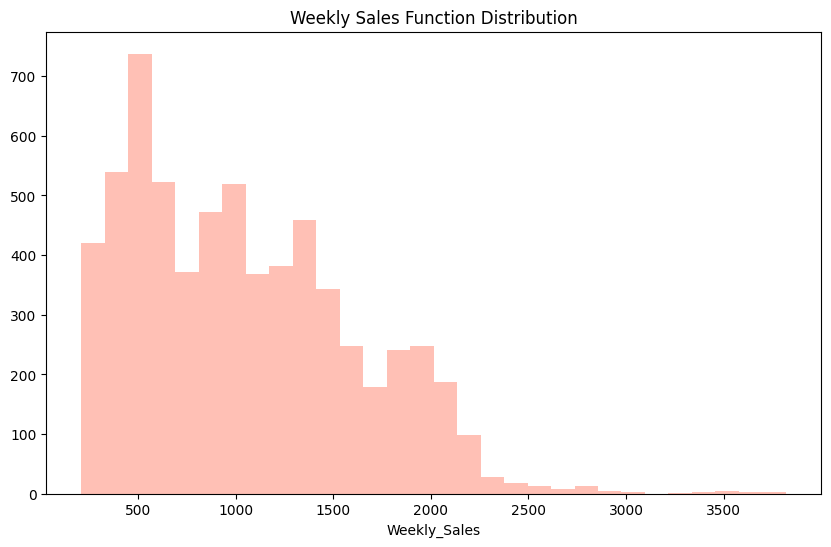

In [343]:
# From the Describe function we see that weekly sales for each store are very high. 
# we will scale down the value for ease of use and revert back when we look residuals or where necessary

plt.figure(figsize=(10, 6))
data["Weekly_Sales"]=data.Weekly_Sales/1000

sns.distplot(data.Weekly_Sales, kde=False, bins=30, color = 'tomato')
plt.title('Weekly Sales Function Distribution')
plt.show()



In the Distribution, natural Log of Sales and the square root of Sales look better distributed. We can use Natural Log for predictions later


In [344]:
def scatter(dataset, column):
    plt.figure()
    plt.scatter(data[column] , data['Weekly_Sales'], color = 'turquoise')
    plt.ylabel('Weekly Sales')
    plt.xlabel(column)

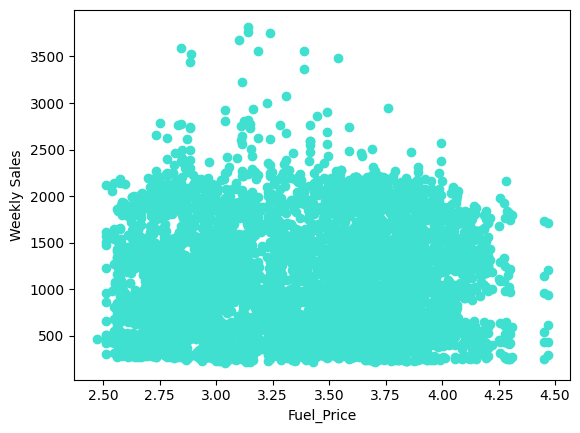

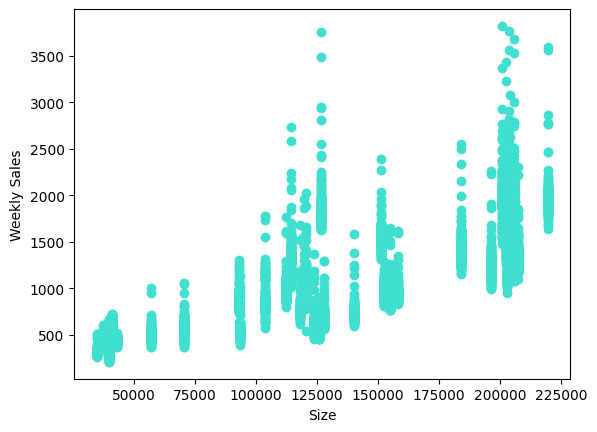

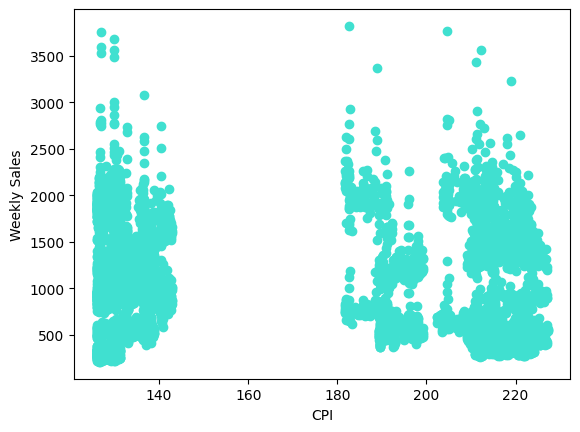

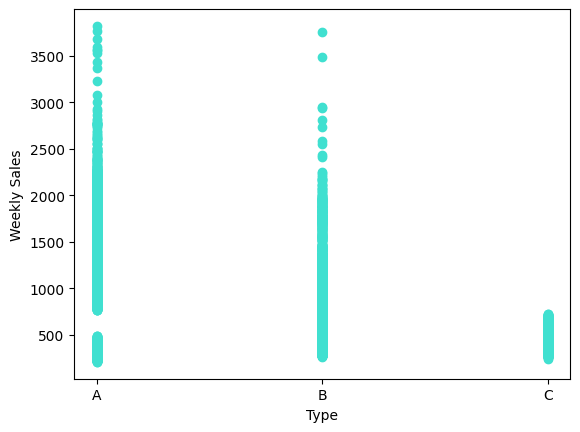

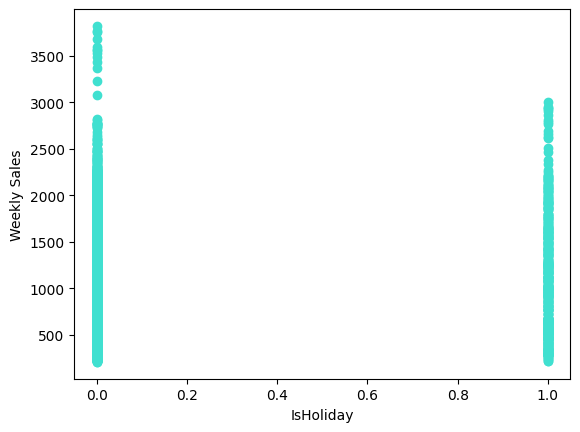

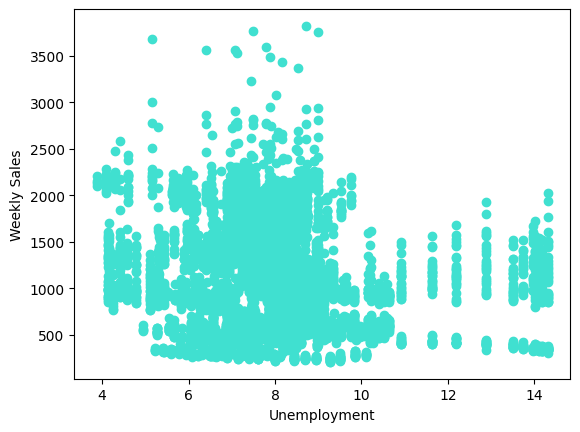

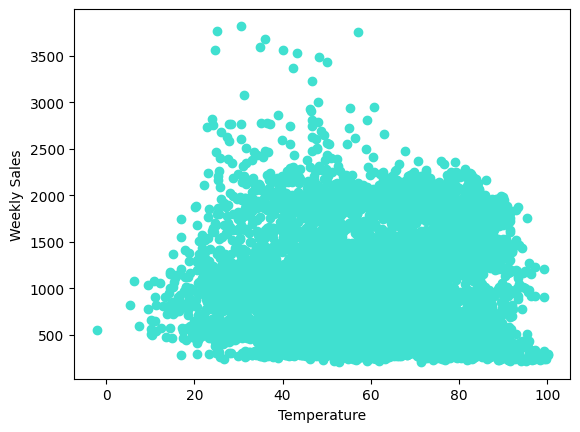

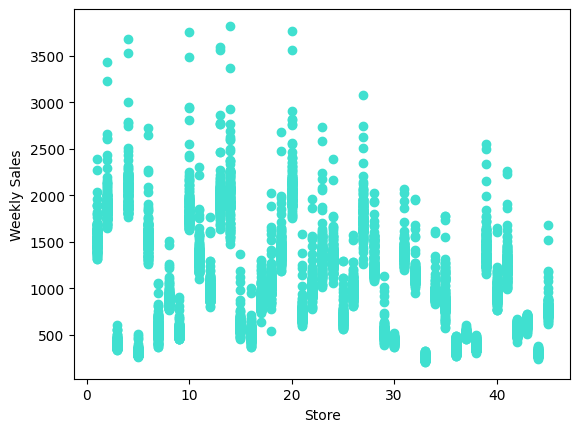

In [345]:
scatter(data, 'Fuel_Price')
scatter(data, 'Size')
scatter(data, 'CPI')
scatter(data, 'Type')
scatter(data, 'IsHoliday')
scatter(data, 'Unemployment')
scatter(data, 'Temperature')
scatter(data, 'Store')


In [346]:
data['Week'] = data.Date.dt.isocalendar().week 

In [347]:
data.head()

Store       Date  Weekly_Sales Type    Size  Temperature  Fuel_Price  \
0      1 2010-02-05    1643.69090    A  151315        42.31       2.572   
1      1 2010-02-12    1641.95744    A  151315        38.51       2.548   
2      1 2010-02-19    1611.96817    A  151315        39.93       2.514   
3      1 2010-02-26    1409.72759    A  151315        46.63       2.561   
4      1 2010-03-05    1554.80668    A  151315        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment  IsHoliday  Day Month  Year  MarkdownsSum  Week  
0         8.106          0    5   Feb  2010           0.0     5  
1         8.106          1   12   Feb  2010           0.0     6  
2         8.106          0   19   Feb  2010           0.0     7  
3         8.106          0   26   Feb  2010           0.0     8  
4         8.106          0    5   Mar  2010           0.0     9

In [348]:
weekly_sales_2010

Week
5     1105.572011
6     1074.148392
7     1072.822084
8      977.079358
9     1041.588229
10    1020.564367
11     999.754992
12     980.754690
13    1120.529584
14    1052.562010
15    1004.081491
16     994.098946
17     971.225038
18    1077.849856
19    1007.335116
20    1002.669068
21    1061.277835
22    1115.300958
23    1062.812149
24    1058.267694
25    1035.756362
26    1087.055211
27    1064.433986
28    1027.642213
29     997.529980
30     991.785854
31    1071.222203
32    1032.542631
33    1045.798954
34    1020.216454
35    1048.761280
36    1014.097730
37     957.349478
38     919.078098
39     938.663908
40    1002.288316
41     958.877188
42     957.037100
43     968.951799
44    1017.377375
45    1024.995574
46    1002.790760
47    1462.688961
48    1109.089508
49    1237.039342
50    1373.795552
51    1798.475902
52     898.500422
Name: Weekly_Sales, dtype: float64

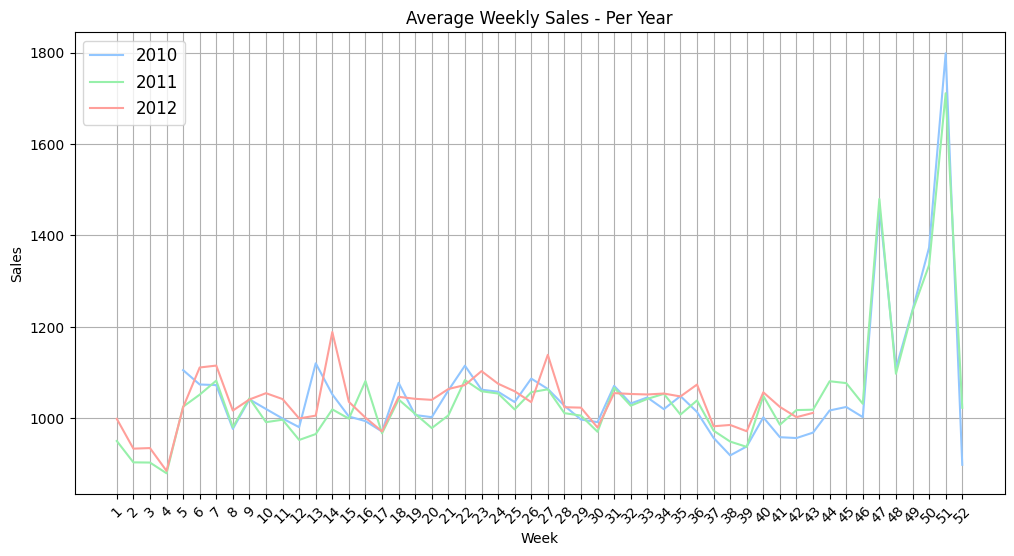

In [349]:
# Calculate average weekly sales for each year
weekly_sales_2010 = data[data.Year == 2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = data[data.Year == 2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = data[data.Year == 2012].groupby('Week')['Weekly_Sales'].mean()

# Plot the data
plt.figure(figsize=(12, 6))

plt.plot(weekly_sales_2010.index, weekly_sales_2010, label='2010')
plt.plot(weekly_sales_2011.index, weekly_sales_2011, label='2011')
plt.plot(weekly_sales_2012.index, weekly_sales_2012, label='2012')

# Customize the plot
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(loc='best', fontsize=12)
plt.xticks(rotation=45)  # Rotating x-axis labels for better visibility
plt.title('Average Weekly Sales - Per Year')
plt.ylabel('Sales')
plt.xlabel('Week')

# Show the plot
plt.show()

#### Note :

**As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks.**

In 2010 is in Week 13

In 2011, Week 16

Week 14 in 2012

Week 13 in 2013 for **Test set**

**So, we can change to 'True' these Weeks in each Year.**

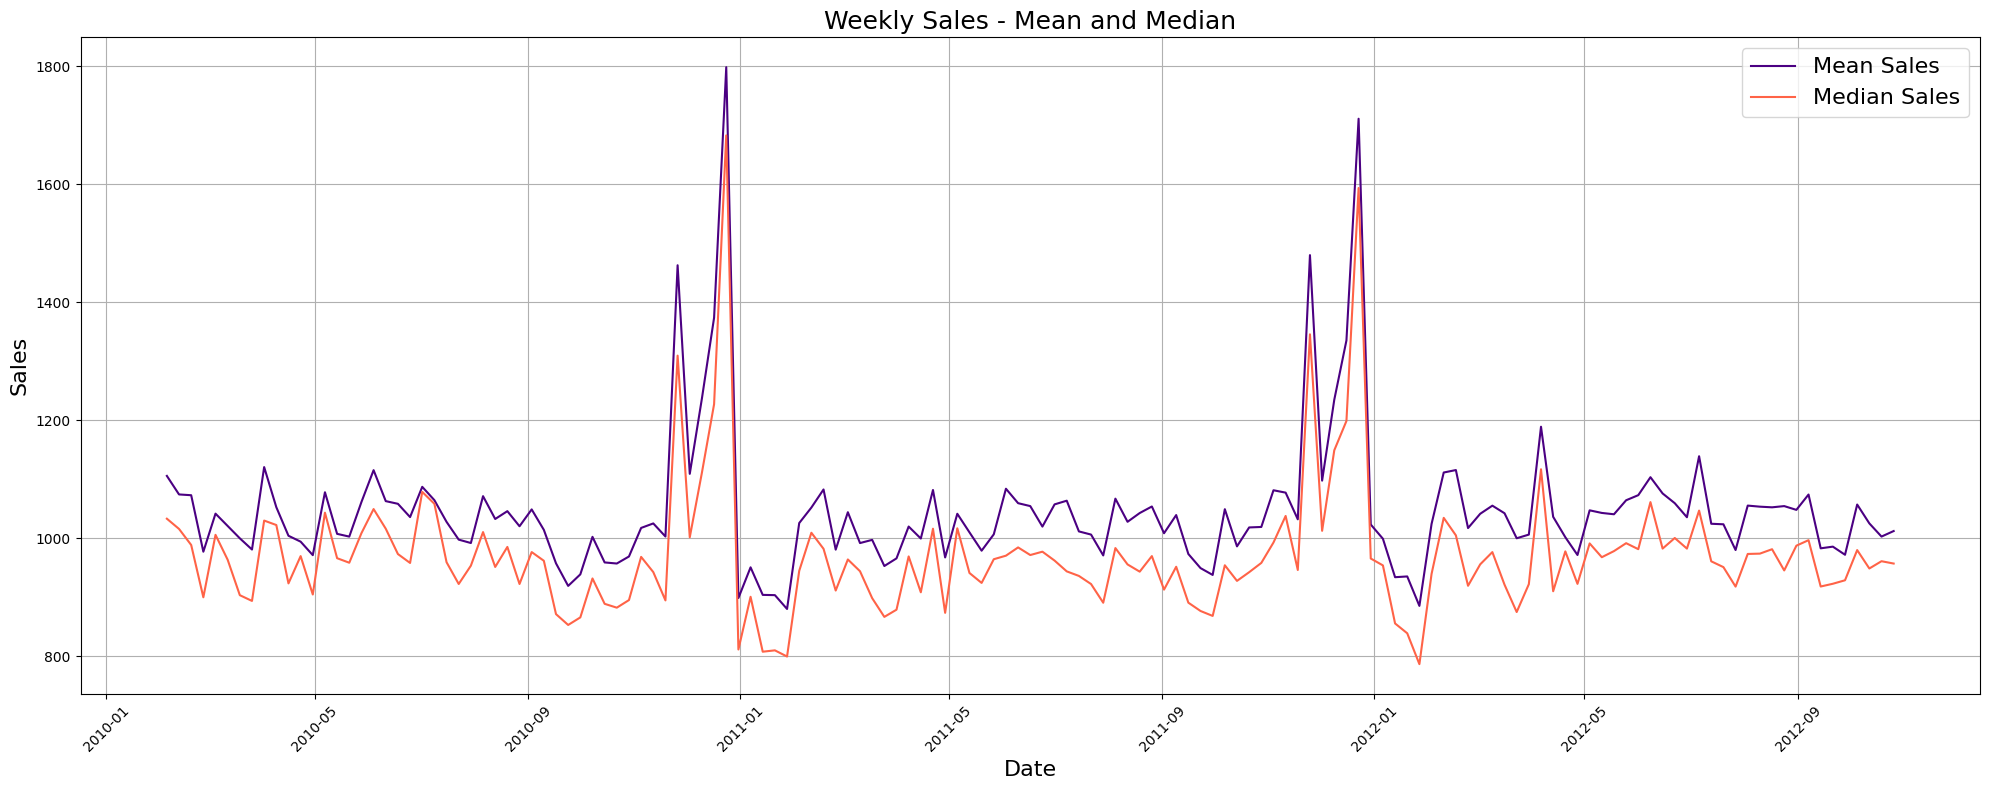

In [350]:
weekly_sales_mean = data['Weekly_Sales'].groupby(data['Date']).mean()
weekly_sales_median = data['Weekly_Sales'].groupby(data['Date']).median()

plt.figure(figsize=(20, 8))
plt.plot(weekly_sales_mean.index, weekly_sales_mean.values, color='indigo', label='Mean Sales')
plt.plot(weekly_sales_median.index, weekly_sales_median.values, color='tomato', label='Median Sales')
plt.grid()
plt.legend(loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.xticks(rotation=45)  # Rotating x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Checking the relationship of the other features with weekly sales</p> 

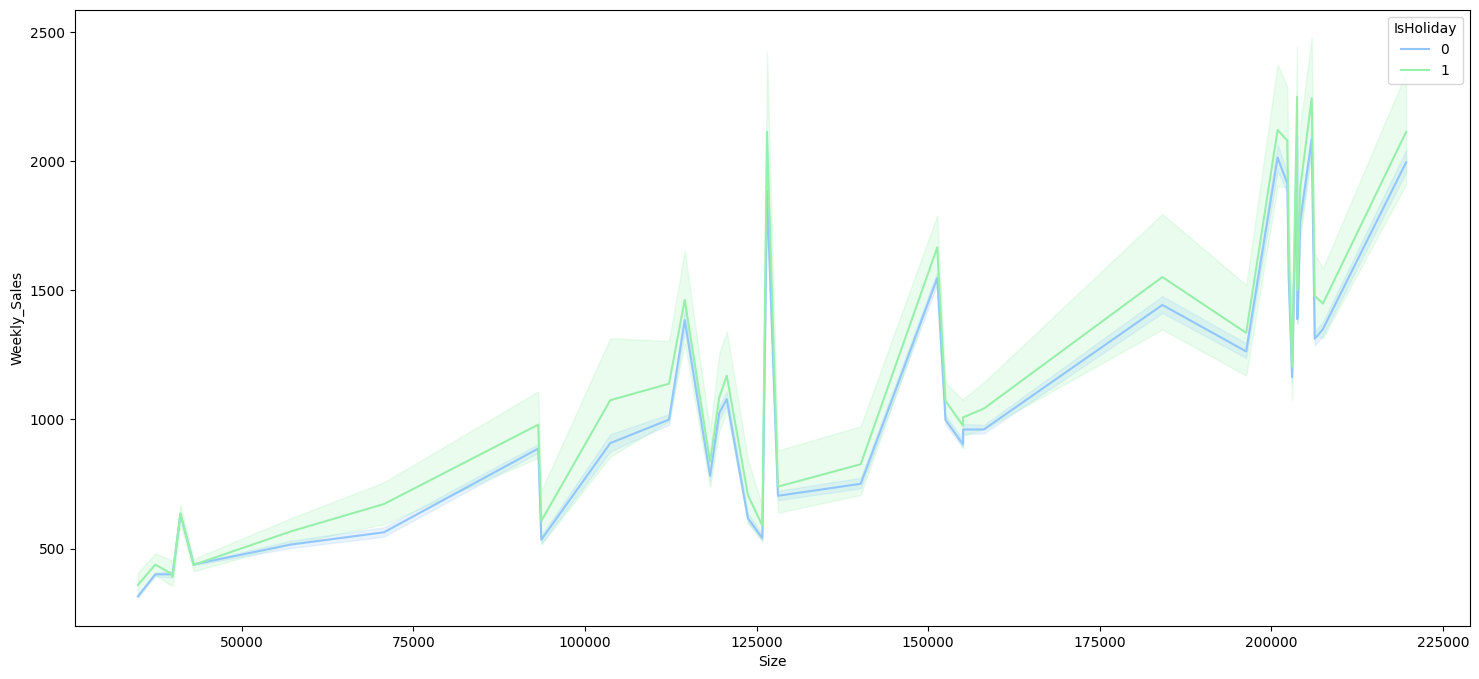

In [351]:
plt.figure(figsize=(18,8))
sns.lineplot ( data = data, x = 'Size', y =  'Weekly_Sales', hue = 'IsHoliday');

In [352]:
px.histogram(data, x='Temperature', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [353]:
px.histogram(data, x='Fuel_Price', y ='Weekly_Sales', color='IsHoliday', marginal='box')

In [354]:
px.histogram(data, x='CPI', y ='Weekly_Sales', color='IsHoliday')

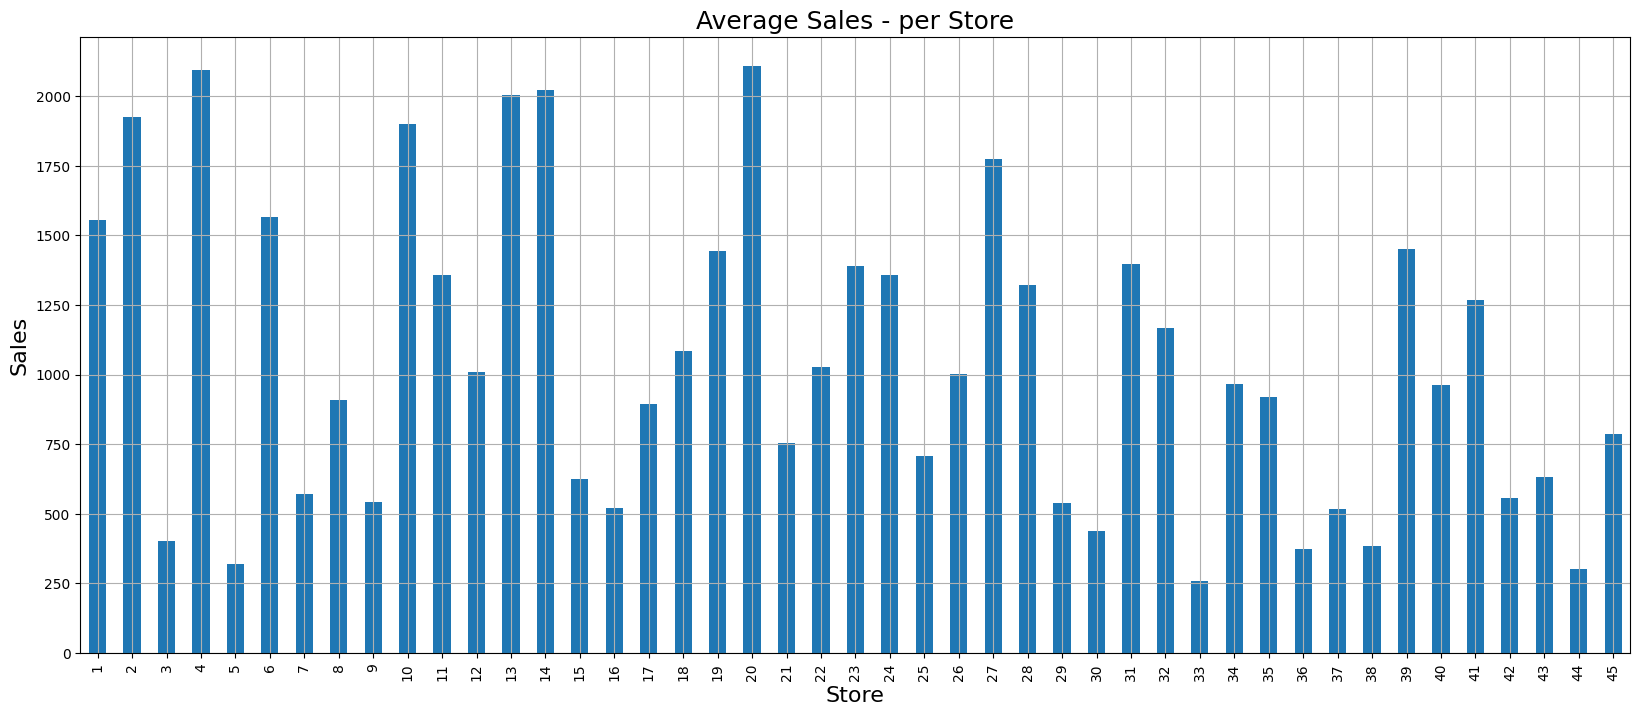

In [355]:
weekly_sales = data['Weekly_Sales'].groupby(data['Store']).mean()
plt.figure(figsize=(20,8))
plt.style.use('default')
weekly_sales.plot(kind="bar")
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Detailed Time-Series Analysis</p>

![](https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/69aa52fb-b692-463f-84c1-cde2470445ae/css-animation-craziness.gif)
![](https://windenergyscience.com/wp-content/uploads/2020/02/Data.gif)



<p style="background-color:white;font-family:calibri;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> What is Time Series</p> 

Any data recorded with some fixed interval of time is called as time series data. This fixed interval can be hourly, daily, monthly or yearly. e.g. hourly temp reading, daily changing fuel prices, monthly electricity bill, annul company profit report etc. In time series data, time will always be independent variable and there can be one or many dependent variable. 

Sales forecasting time series with shampoo sales for every month will look like this, 

![Shampoo_Sales](https://raw.githubusercontent.com/satishgunjal/images/master/Shampoo_Sales.png)

In above example since there is only one variable dependent on time so its called as univariate time series. If there are multiple dependent variables, then its called as multivariate time series.

Objective of time series analysis is to understand how change in time affect the dependent variables and accordingly predict values for future time intervals.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Stationarity Data</p> 

For accurate analysis and forecasting trend and seasonality is removed from the time series and converted it into stationary series.
Time series data is said to be stationary when statistical properties like mean, standard deviation are constant and there is no seasonality. In other words statistical properties of the time series data should not be a function of time.

![Stationarity](https://raw.githubusercontent.com/satishgunjal/images/master/Stationarity.png)

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Test for Stationarity</p>

Easy way is to look at the plot and look for any obvious trend or seasonality. While working on real world data we can also use more sophisticated methods like rolling statistic and Augmented Dickey Fuller test to check stationarity of the data. 

### Rolling Statistics <a id ="11"></a>
In rolling statistics technique we define a size of window to calculate the mean and standard deviation throughout the series. For stationary series mean and standard deviation shouldn't change with time.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Augmented Dickey Fuller (ADF) Test</p>

I won't go into the details of how this test works. I will concentrate more on how to interpret the result of this test to determine the stationarity of the series. ADF test will return 'p-value' and 'Test Statistics' output values.
* **p-value > 0.05**: non-stationary.
* **p-value <= 0.05**: stationary.
* **Test statistics**: More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series


![](https://i.pinimg.com/originals/cc/fe/1f/ccfe1f7fee5fe18a65127d4ed1f4c036.gif)


### We will consider one of the stores and perform a detailed time-series analysis on it

### Store 4

In [356]:
data1 = pd.read_csv('train.csv')
data1.set_index('Date', inplace=True)

store4 = data1[data1.Store == 4]
# there are about 45 different stores in this dataset.

sales4 = pd.DataFrame(store4.Weekly_Sales.groupby(store4.index).sum())
sales4.dtypes
sales4.head(20)
# Grouped weekly sales by store 4

Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
2010-03-12    1894324.09
2010-03-19    1897429.36
2010-03-26    1762539.30
2010-04-02    1979247.12
2010-04-09    1818452.72
2010-04-16    1851519.69
2010-04-23    1802677.90
2010-04-30    1817273.28
2010-05-07    2000626.14
2010-05-14    1875597.28
2010-05-21    1903752.60
2010-05-28    1857533.70
2010-06-04    1903290.58
2010-06-11    1870619.23
2010-06-18    1929736.35

In [357]:
#remove date from index to change its dtype because it clearly isnt acceptable.
sales4.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales4['Date'] = pd.to_datetime(sales4['Date'])
# resetting date back to the index
sales4.set_index('Date',inplace = True)

sales4

Weekly_Sales
Date                    
2010-02-05    2135143.87
2010-02-12    2188307.39
2010-02-19    2049860.26
2010-02-26    1925728.84
2010-03-05    1971057.44
...                  ...
2012-09-28    2027620.23
2012-10-05    2209835.43
2012-10-12    2133026.07
2012-10-19    2097266.85
2012-10-26    2149594.46

[143 rows x 1 columns]

### Store 6

In [358]:
# Lets take store 6 data for analysis
store6 = data1[data1.Store == 6]
# there are about 45 different stores in this dataset.

sales6 = pd.DataFrame(store6.Weekly_Sales.groupby(store6.index).sum())
sales6.dtypes
# Grouped weekly sales by store 6

#remove date from index to change its dtype because it clearly isnt acceptable.
sales6.reset_index(inplace = True)

#converting 'date' column to a datetime type
sales6['Date'] = pd.to_datetime(sales6['Date'])
# resetting date back to the index
sales6.set_index('Date',inplace = True)

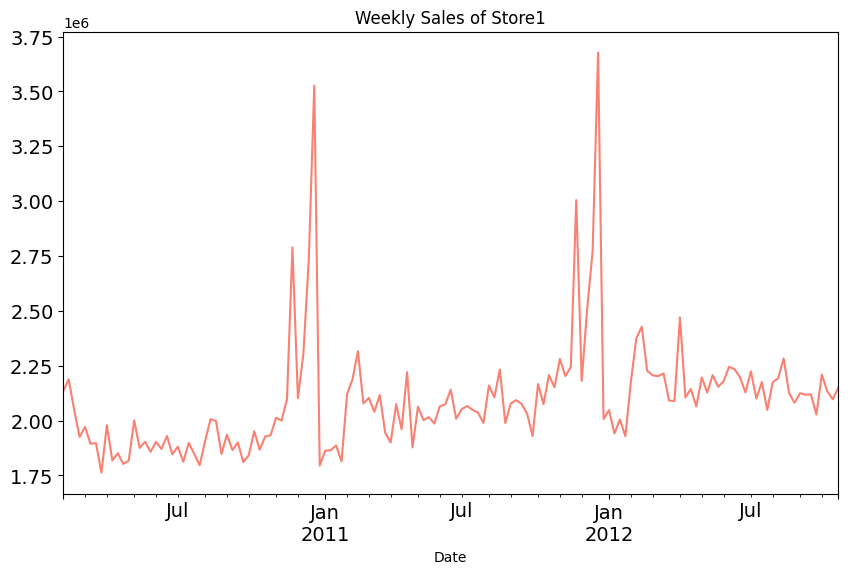

In [359]:
sales4.Weekly_Sales.plot(figsize=(10,6), title= 'Weekly Sales of Store1', fontsize=14, color = 'salmon')
plt.show()

# <p style="background-color:white;font-family:newtimeroman;color:coral;font-size:150%;text-align:center;border-radius:20px 60px;">Time Series Components</p>


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Time Series Characteristics</p>

Mean, standard deviation and seasonality defines different characteristics of the time series. 

![Time_Series_Characteristics](https://raw.githubusercontent.com/satishgunjal/images/master/Time_Series_Characteristics.png)

Important characteristics of the time series are as below

### Trend <a id ="3"></a>
Trend represent the change in dependent variables with respect to time from start to end. In case of increasing trend dependent variable will increase with time and vice versa. It's not necessary to have definite trend in time series, we can have a single time series with increasing and decreasing trend. In short trend represent the varying mean of time series data.

![Trend](https://raw.githubusercontent.com/satishgunjal/images/master/Trend.png)

### Seasonality <a id ="4"></a>
If observations repeats after fixed time interval then they are referred as seasonal observations. These seasonal changes in data can occur because of natural events or man-made events. For example every year warm cloths sales increases just before winter season. So seasonality represent the data variations at fixed intervals.

![Seasonality](https://raw.githubusercontent.com/satishgunjal/images/master/Seasonality.png)

### Irregularities <a id ="5"></a>
This is also called as noise. Strange dips and jump in the data are called as irregularities. These fluctuations are caused by uncontrollable events like earthquakes, wars, flood, pandemic etc. For example because of COVID-19 pandemic there is huge demand for hand sanitizers and masks.

![Irregularities](https://raw.githubusercontent.com/satishgunjal/images/master/Irregularities.png)

### Cyclicity <a id ="6"></a>
Cyclicity occurs when observations in the series repeats in random pattern. Note that if there is any fixed pattern then it becomes seasonality, in case of cyclicity observations may repeat after a week, months or may be after a year. These kinds of patterns are much harder to predict.

![Cyclicity](https://raw.githubusercontent.com/satishgunjal/images/master/Cyclicity.png)

Time series data which has above characteristics is called as 'Non-Stationary Data'. For any analysis on time series data we must convert it to 'Stationary Data'

The general guideline is to estimate the trend and seasonality in the time series, and then make the time series stationary for data modeling. In data modeling step statistical techniques are used for time series analysis and forecasting. Once we have the predictions, in the final step forecasted values converted into the original scale by applying trend and seasonality constraints back.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Time Series Analysis</p>
As name suggest its analysis of the time series data to identify the patterns in it. I will briefly explain the different techniques and test for time series data analysis.

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Time Series Decomposition</p>
Time series decomposition helps to deconstruct the time series into several component like trend and seasonality for better visualization of its characteristics. Using time-series decomposition makes it easier to quickly identify a changing mean or variation in the data

![Decomposition_of_Time_Series](https://raw.githubusercontent.com/satishgunjal/images/master/Decomposition_of_Time_Series.png)

### Additive Decomposition

* An additive model suggests that the components are added together.
* An additive model is linear where changes over time are consistently made by the same amount.
* A linear seasonality has the same frequency (width of the cycles) and amplitude (height of the cycles).

The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). You need to specify whether the model is additive or multiplicative.

The seasonal_decompose() function returns a result object which contains arrays to access four pieces of data from the decomposition.

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/


<Figure size 640x480 with 0 Axes>

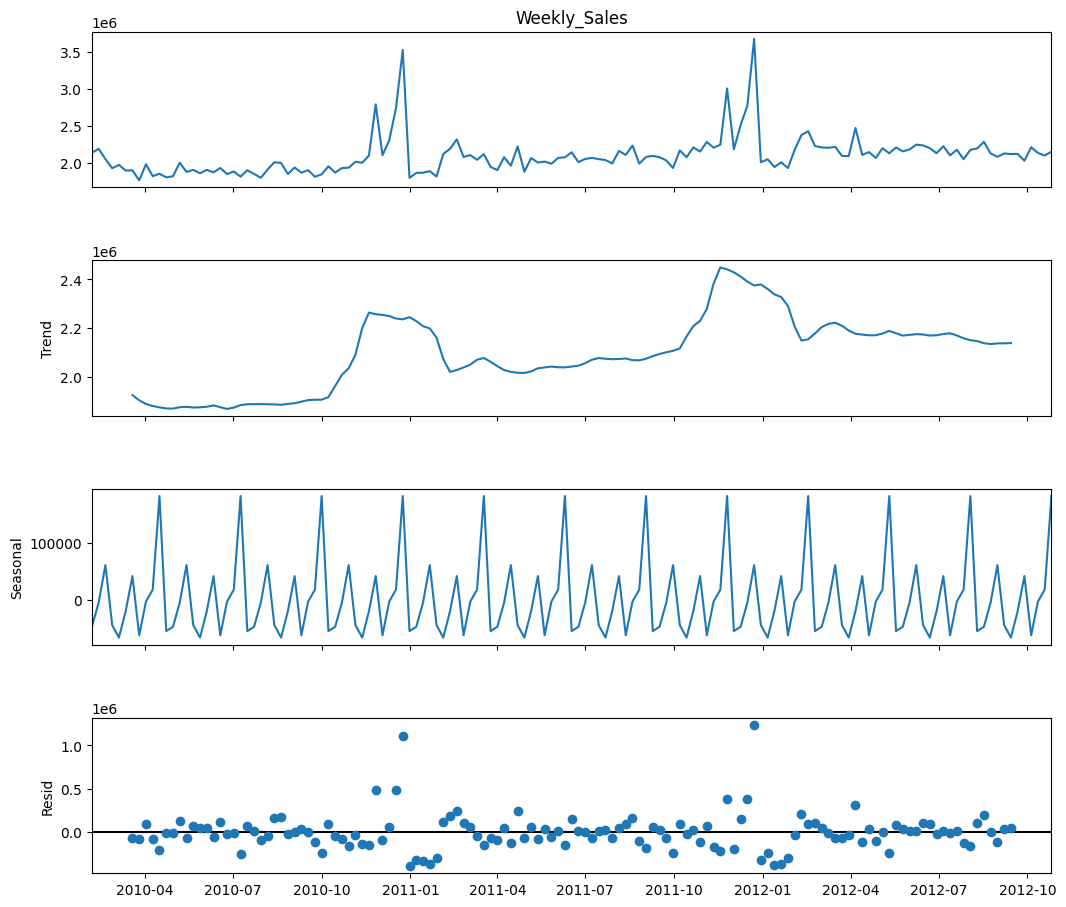

In [360]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales4.Weekly_Sales, period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()



### Multiplicative Decomposition

* An multiplicative model suggests that the components are multipled together.
* An multiplicative model is non-linear such as quadratic or exponential. 
* Changes increase or decrease over time.
* A non-linear seasonality has an increasing or decreasing frequency (width of the cycles) and / or amplitude (height of the cycles) over time.

<Figure size 640x480 with 0 Axes>

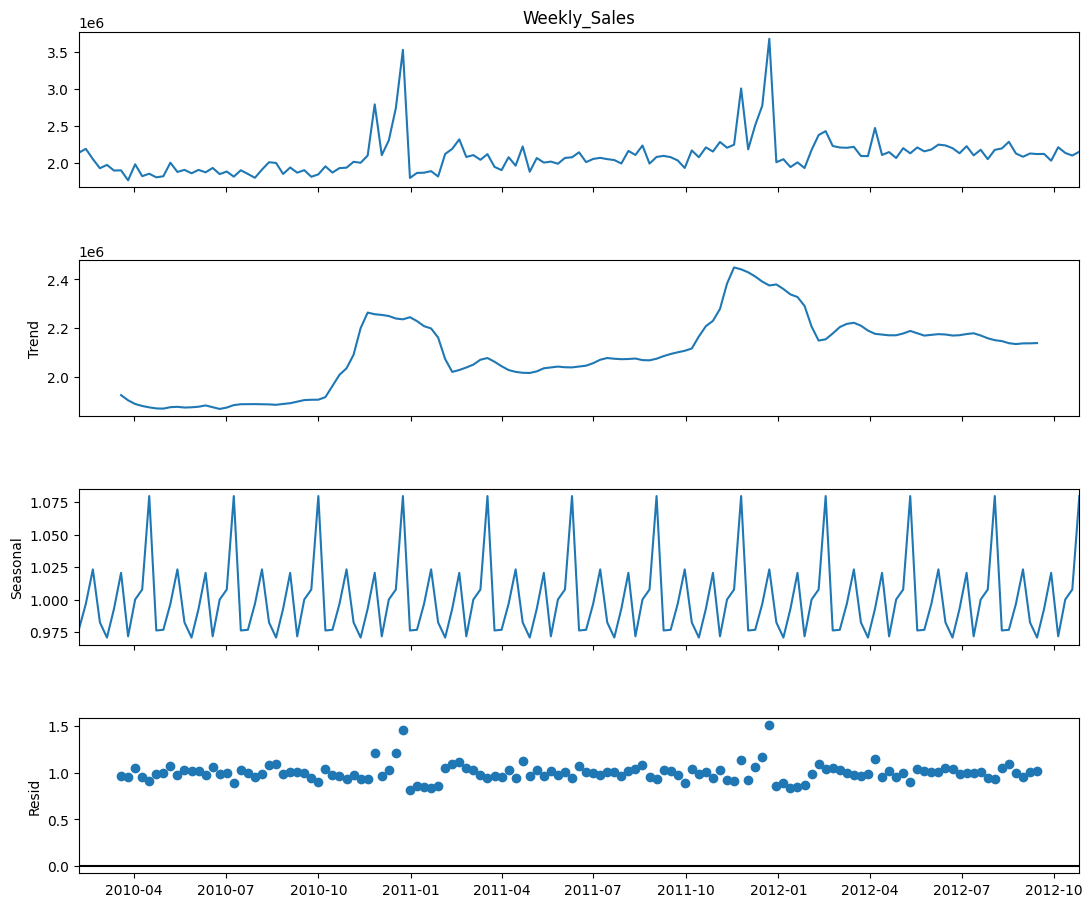

In [361]:
decomposition = seasonal_decompose(sales4.Weekly_Sales, model= 'multiplicative', period=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

In [362]:
y1=sales4.Weekly_Sales
y2=sales6.Weekly_Sales

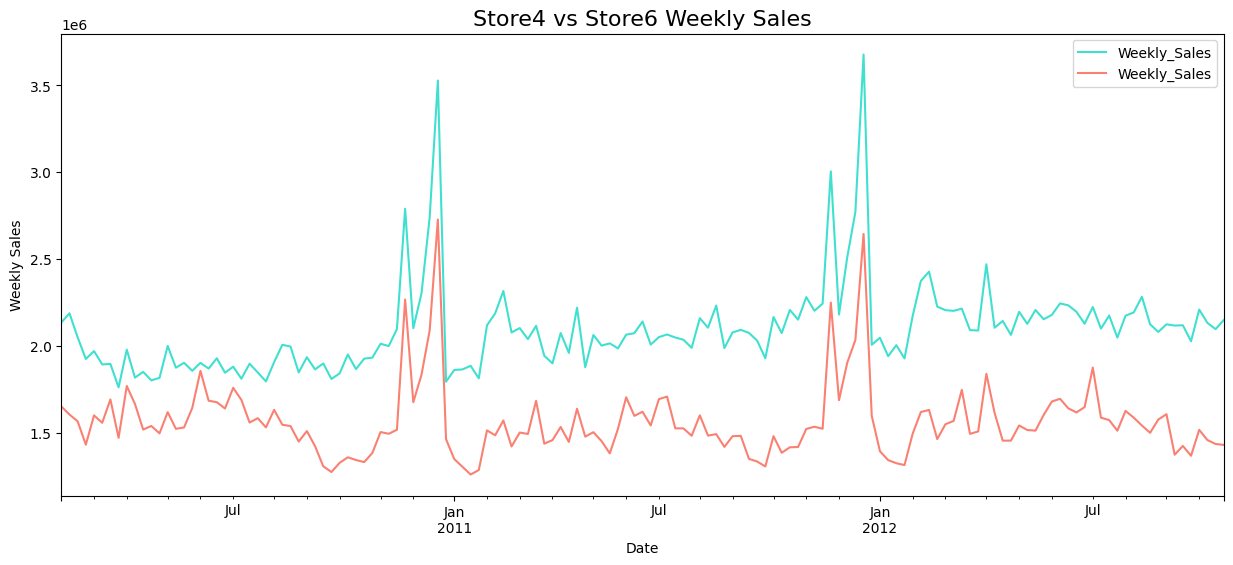

In [363]:
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 Weekly Sales', fontsize = '16')
plt.show()

#### This shows an interesting trend during year ends (during both 2011 & 2012). The best thing is both the stores have almost the same trends and spike just the magnitude is different. 
    This clearly tells its a timeseries problem and it will be interesting to look more into it

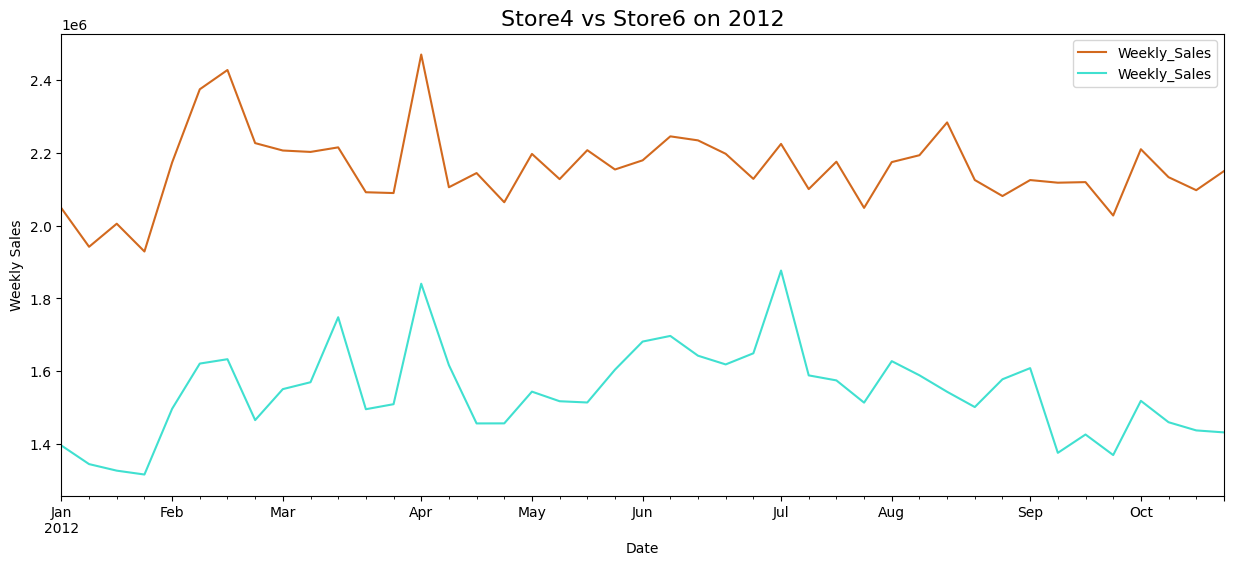

In [364]:
# Lets Look into 2012 data for a better view
y1['2012'].plot(figsize=(15, 6),legend=True, color = 'chocolate')
y2['2012'].plot(figsize=(15, 6), legend=True, color = 'turquoise')
plt.ylabel('Weekly Sales')
plt.title('Store4 vs Store6 on 2012', fontsize = '16')
plt.show()

#### Not quite a trend. Here comes yet another component of timeseries - Irregular component

    which are other non random sources of variations of series and are mainly the impact of random events such as strikes, earthquakes, and sudden changes in the weather. By their nature, these effects are completely unpredictable.

In [365]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 5)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [366]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(4, 4, 3),
                                seasonal_order=(1, 1, 0, 52),   #enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7459      0.544     -3.211      0.001      -2.812      -0.680
ar.L2         -1.2817      0.583     -2.197      0.028      -2.425      -0.138
ar.L3         -0.5903      0.250     -2.357      0.018      -1.081      -0.099
ar.L4         -0.1881      0.091     -2.058      0.040      -0.367      -0.009
ma.L1         -1.3814      0.493     -2.805      0.005      -2.347      -0.416
ma.L2         -0.2160      1.061     -0.204      0.839      -2.295       1.863
ma.L3          0.6015      0.593      1.015      0.310      -0.560       1.764
ar.S.L52      -0.0665      0.049     -1.369      0.171      -0.162       0.029
sigma2      1.622e+10   5.61e-11   2.89e+20      0.000    1.62e+10    1.62e+10


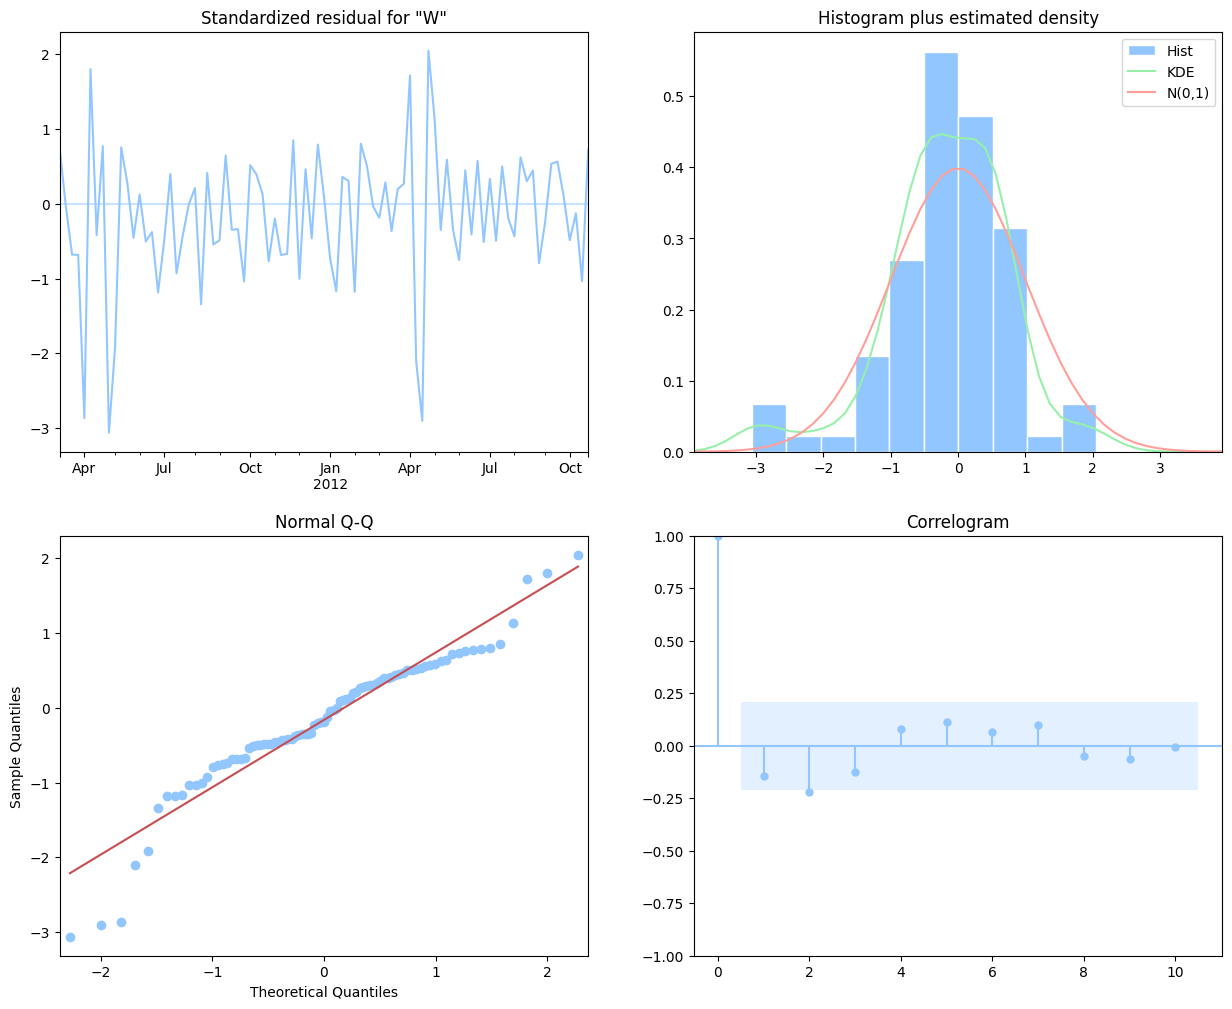

In [367]:
plt.style.use('seaborn-pastel')
results.plot_diagnostics(figsize=(15, 12))
plt.show()


In [368]:
# Will predict for last 90 days. So setting the date according to that
pred = results.get_prediction(start=pd.to_datetime('2012-07-27'), dynamic=False)
pred_ci = pred.conf_int()

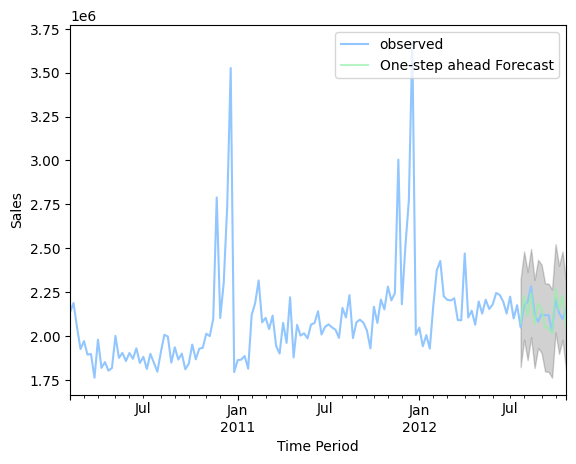

In [369]:
ax = y1['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [370]:
y_forecasted = pred.predicted_mean
y_truth = y1['2012-7-27':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4756410698.6


In [371]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-7-27'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

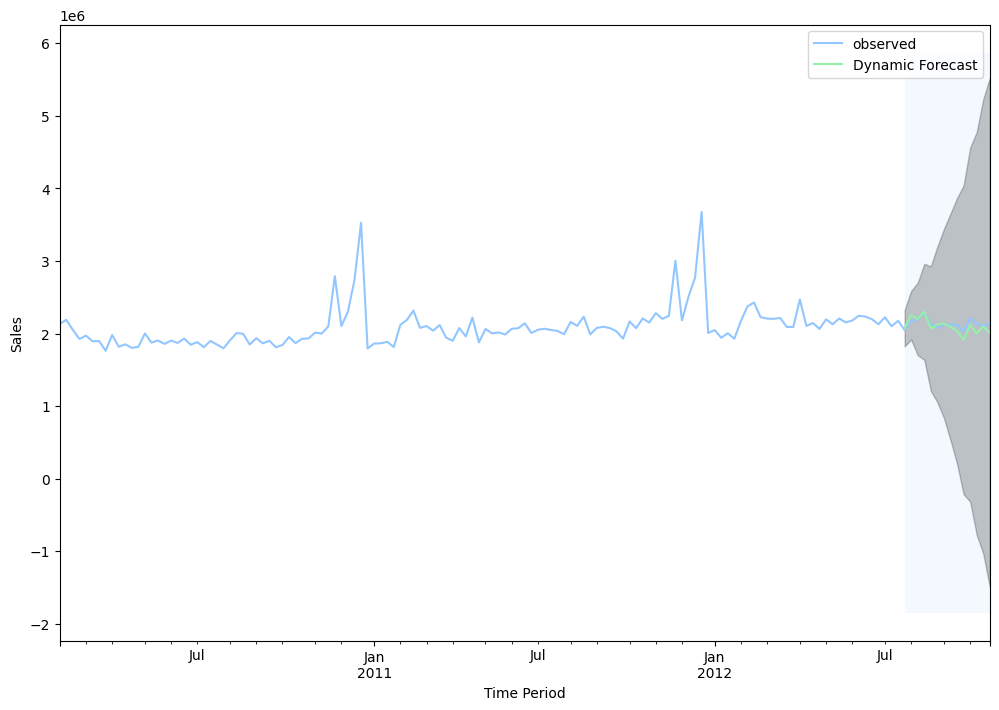

In [372]:
ax = y1['2010':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2012-7-26'), y1.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### That looks good. Both the observed and predicted lines go together indicating nearly accurate prediction

In [373]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean

y_truth = y1['2012-7-27':]

# Compute the Root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 73849.68


In [374]:
Residual= y_forecasted - y_truth
print("Residual for Store1",np.abs(Residual).sum())

Residual for Store1 821209.5250462727


In [375]:
# Get forecast 12 weeks ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

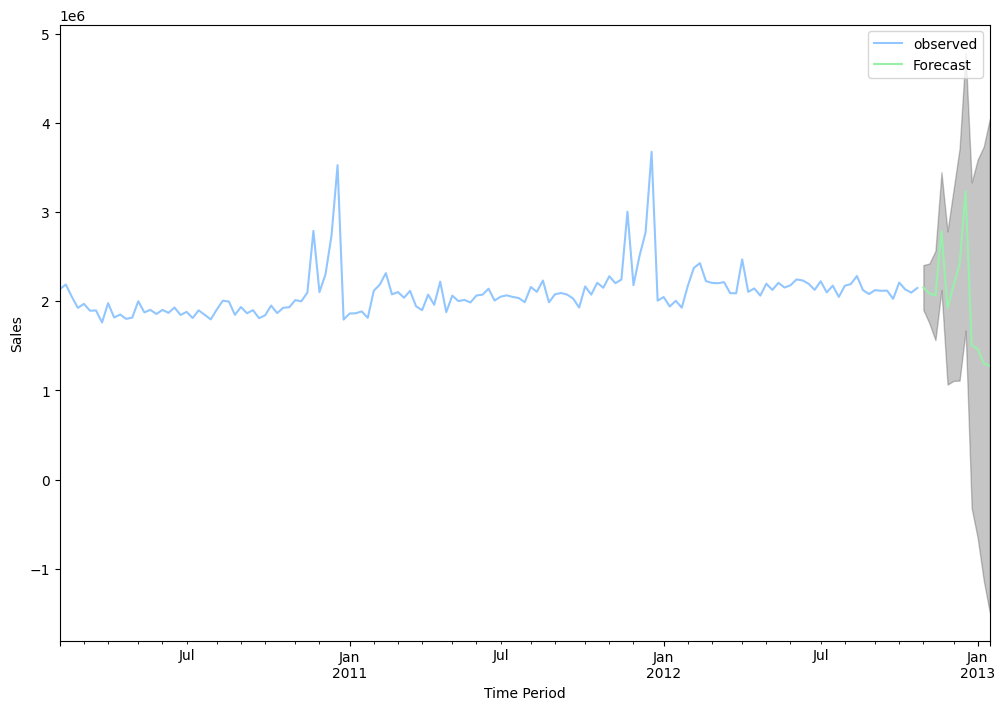

In [376]:
ax = y1.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Time Period')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

#### For future prediction the model is not that great because the error interval is way big. But if we just check the green line prediction this is almost like earlier years. If we look for may be first 2 weeks the prediction is way better and error is also low.


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Modelling & Machine learning</p>

In [377]:
# create dummy variables for 'Type' and keeping all columns to see heatmap then will drop 1 column
Type_dummies = pd.get_dummies(data.Type, prefix='Type')

# concatenate two DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Type_dummies], axis=1)

# Not dropping the orginal Type column now so that I can use the field in some data analysis 

In [378]:
#Create a dataframe for heatmap
data_heatmap_df=data.copy()

# Eliminating all the columns that are not continuous/binary  variables from the heatmap section.
data_heatmap_df.drop(['Store','Day','Month','Year','Date','Store','Type','Type_A','Type_B','Type_C'], axis=1,inplace=True)


# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,8))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, cmap='Pastel1_r')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Statistical analysis and correlations</p>

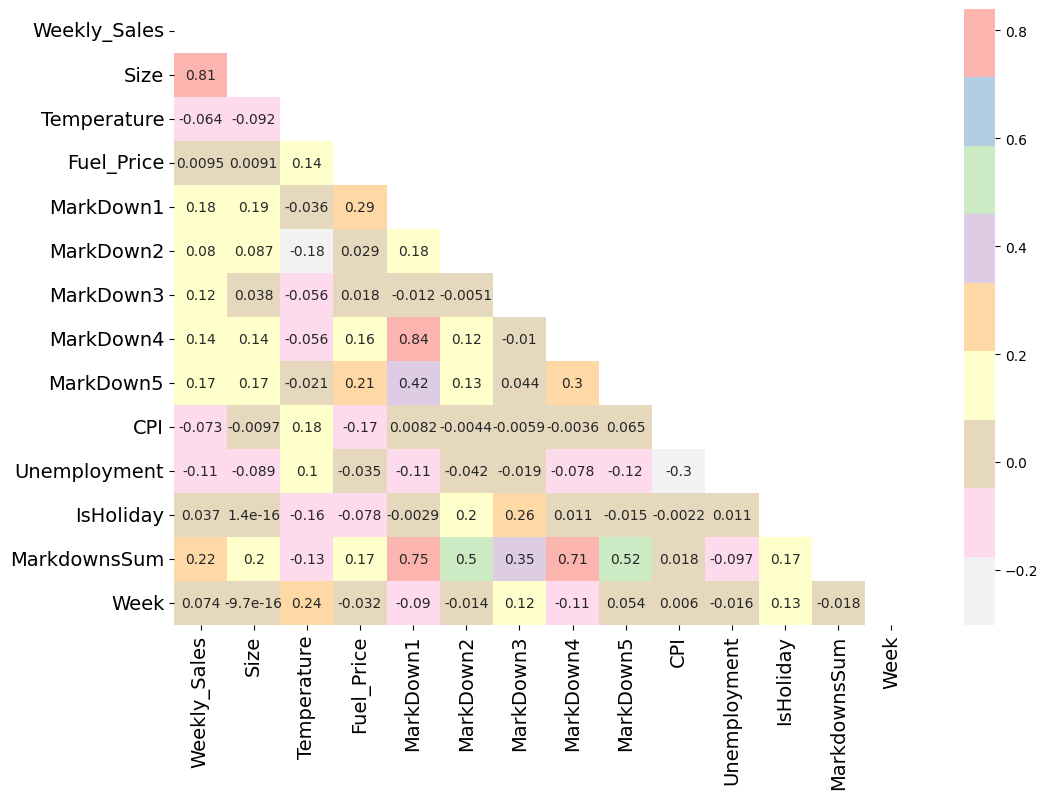

In [379]:
correlation_heat_map(data_heatmap_df)

#inference: By checking the direct correlation of features there is no much promising correlations. 
#           There are no much correlation within the features as well. In a way this is good because 
#           there won't be multicollinearity that we have to take care while running models.



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  Plotting data</p>

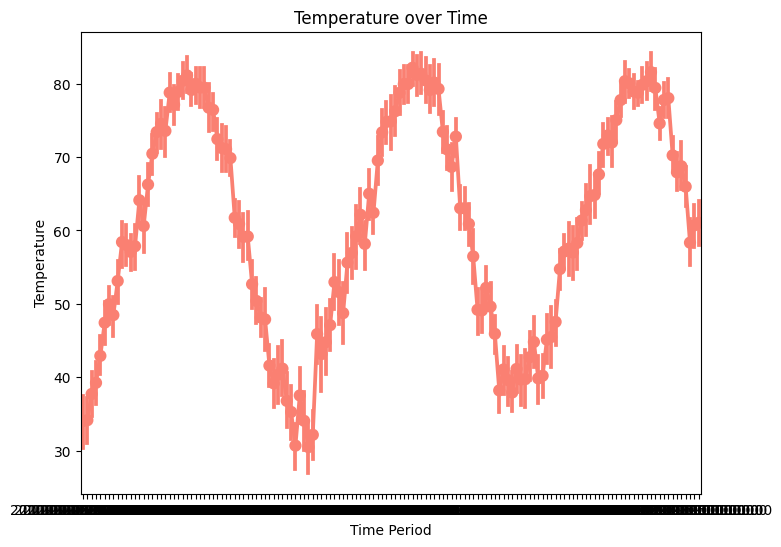

In [380]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Temperature", data=data, color = 'salmon')
plt.xlabel('Time Period')
plt.ylabel('Temperature')
plt.title('Temperature over Time')
plt.show()
# inference: Graph clearly shows Temperature is more of a seasonal and repeated in cycles and this would 
# be an interesting data point that we can use for studies further

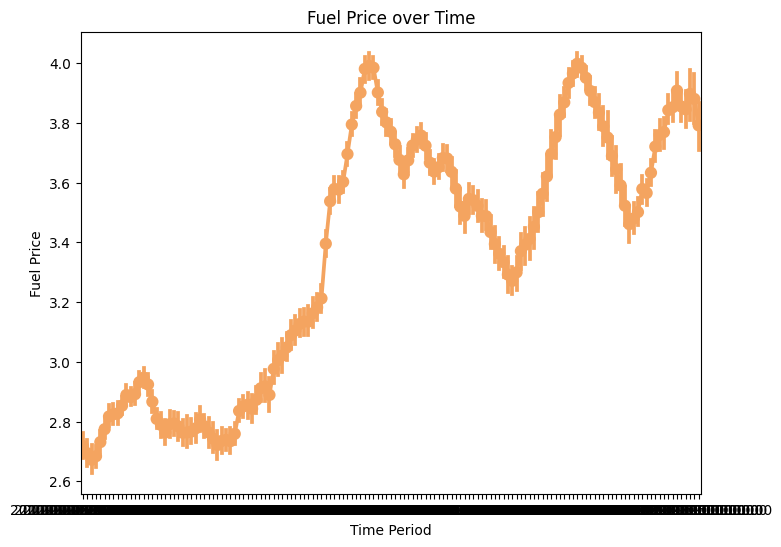

In [381]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Fuel_Price", data=data, color = 'sandybrown')
plt.xlabel('Time Period')
plt.ylabel('Fuel Price')
plt.title('Fuel Price over Time')
plt.show()
# inference: Fuel price varies over time and there are high and lows

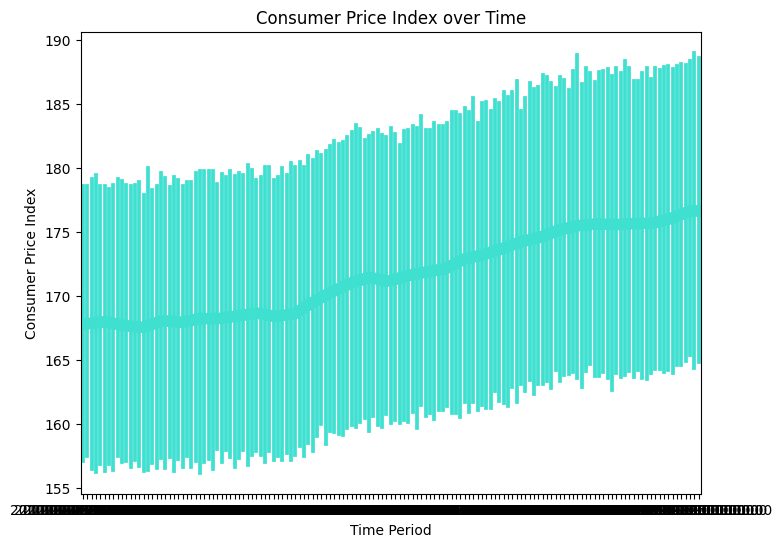

In [382]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="CPI", data=data, color = 'turquoise')
plt.xlabel('Time Period')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index over Time')
plt.show()
# inference: over time CPI have increased. but the change is not much

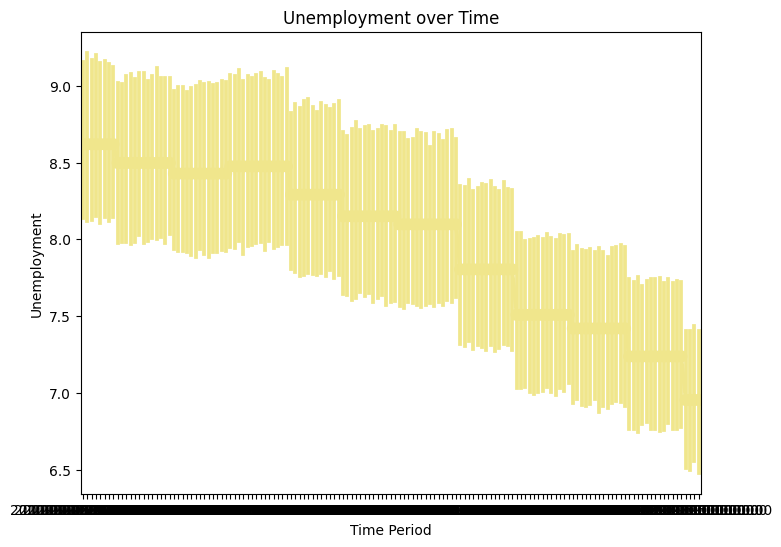

In [383]:
plt.figure(figsize=(8,6))
sns.pointplot(x="Date", y="Unemployment", data=data, color='khaki')
plt.xlabel('Time Period')
plt.ylabel('Unemployment')
plt.title('Unemployment over Time')
plt.show()
# inference:  Over time unemployment have came down we can see this factor also whether it have affected the Sales


**This is interesting. Features over time changes quite a bit. We will see whether these have any effects on Sales while we model**

We know that **Markdown columns have quiet few outliers** it can be because of our imputation as well. So we will treate them later and try implement a better way of imputation. Eg: KNN imputation, Random value between min and max imputation..

**Weekly Sales also seem to have some Outliers but we will keep them as it is for now as they may indicate crucial information.**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;"> Visual analysis</p>

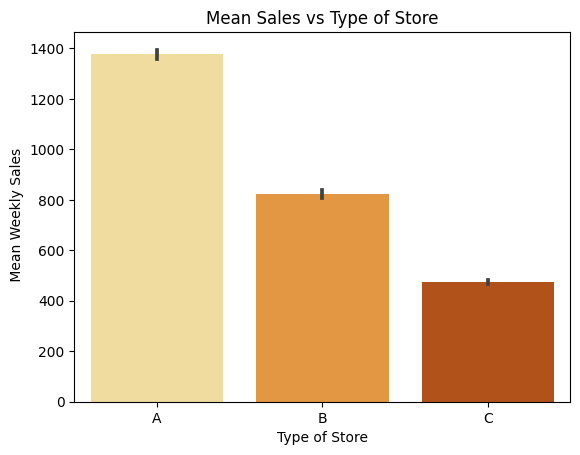

In [384]:
# Checking how the Type of the store have effect on the sales.
col=['coral', 'greenyellow', 'turquoise']
sns.barplot(x="Type", y="Weekly_Sales", data=data,orient='v', palette ='YlOrBr')
plt.xlabel('Type of Store')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean Sales vs Type of Store')
#plt.savefig('./images/Type_vs_Sales.png')
plt.show()

# inference: From the graph its clear that Type A > Type B > Type C in mean weekly sales. 

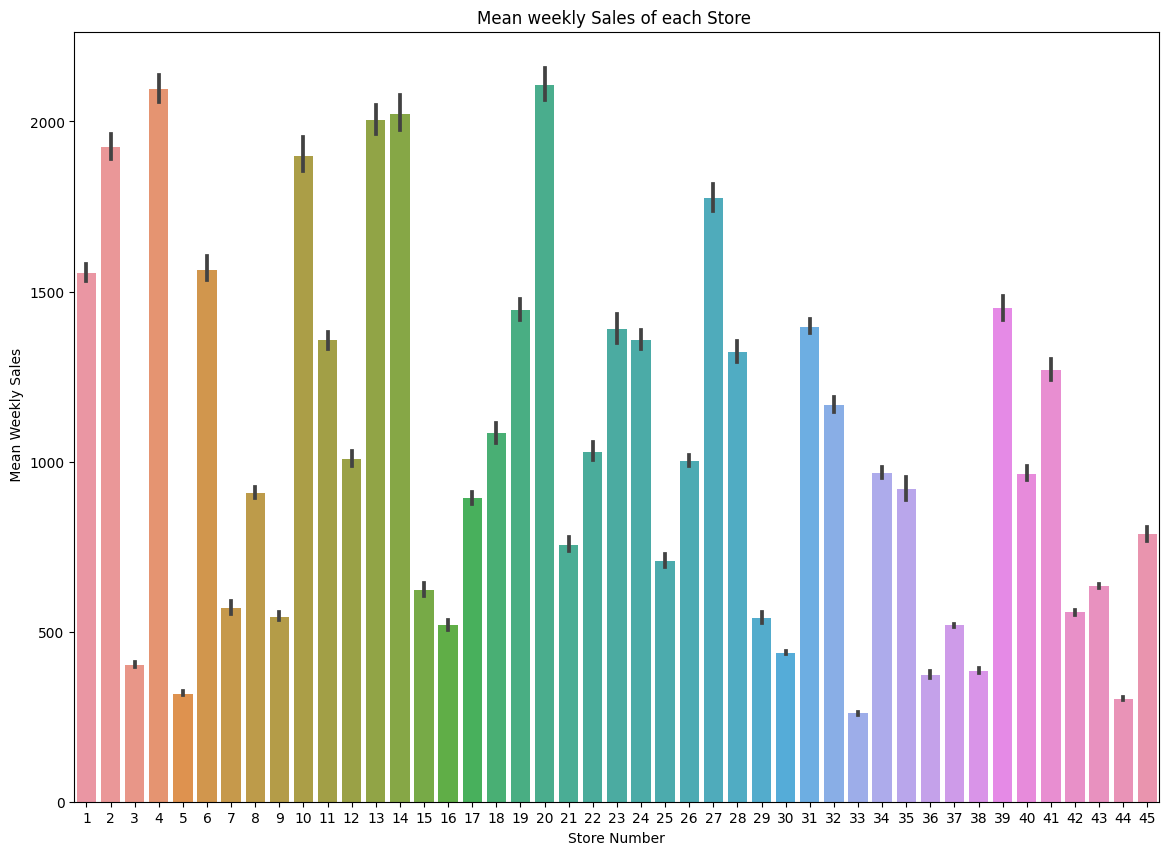

In [385]:
plt.subplots(figsize=(14,10))
sns.barplot(x="Store", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Store Number')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales of each Store ')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Stores.png')
plt.show()

# inference : From the chart we can see that there are stores that have a weekly sales from $250,000  
#             to $2,200,000

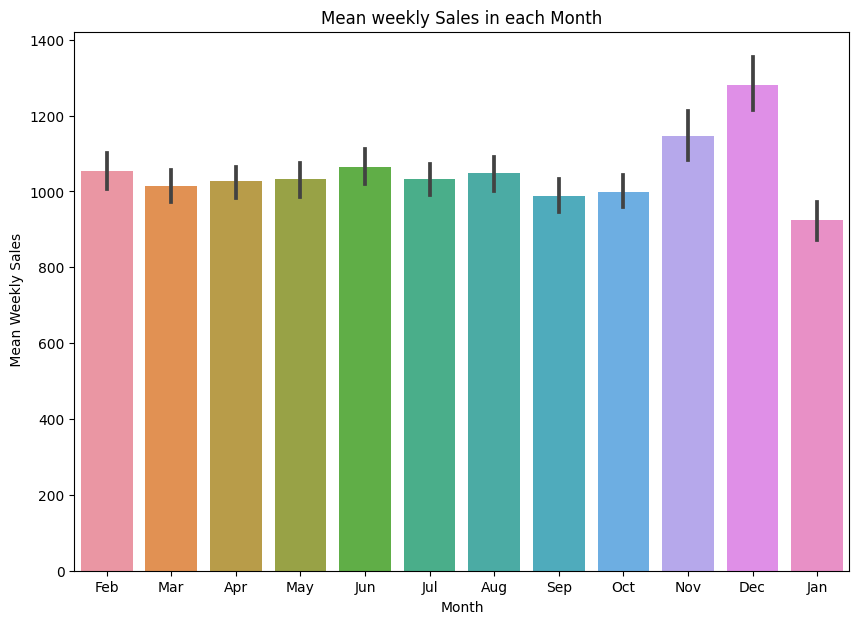

In [386]:
plt.subplots(figsize=(10,7))
sns.barplot(x="Month", y="Weekly_Sales", data=data,orient='v')
plt.xlabel('Month')
plt.ylabel(' Mean Weekly Sales')
plt.title('Mean weekly Sales in each Month')
#plt.savefig('./images/Mean_Weekly_Sales_vs_Months.png')
plt.show()
# inference: Graph shows sales in each month and from this we can see December seems to have a very high sales 
#            compared to every other month and January have the least sales. 

#### With this we come to an end of EDA & Time series analysis. We will now move forward with Machine Learning & Modelling


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:230%;border-radius:20px 60px;"> Feature Engineering </p>

#### Before creating and running model we will look through the columns and make meaningful columns and create dummies where needed. 

**We need to take special care (KNN Imputation) of Markdown5 which has many outlier and as we know Markdown1-5 which have a lot of missing values.** 

We will create dummies for **"Store, Month, Year"**



In [387]:
# Create Week column which says which week of the month it is. 
data["Week"]= round(np.floor(((data.Day-1)/7)+1))

# Create dummies for the columns that are required for later studies
Store_dummies = pd.get_dummies(data.Store, prefix='Store')
Month_dummies = pd.get_dummies(data.Month, prefix='Month')
Year_dummies = pd.get_dummies(data.Year, prefix='Year')
Week_dummies = pd.get_dummies(data.Week, prefix='Week')

# concatenate DataFrames (axis=0 for rows, axis=1 for columns)
data = pd.concat([data, Store_dummies,Month_dummies,Year_dummies,Week_dummies], axis=1)

In [388]:
data_decision=data.iloc[:,:18]

data_decision["Week"]= round(np.floor(((data_decision.Day-1)/7)+1))

In [389]:
# Drop the columns that we have created dummies
data.drop(['Type', 'Store','Month','Year','Day','Week'], axis=1, inplace=True) 

In [390]:
# drop each column from the list of dummies to make it perfect to use in models
data.drop(['Type_C', 'Store_1','Month_Jan','Year_2010','Week_5.0'], axis=1, inplace=True) 



Next, we will perform **KNN (K Nearest Neighbours) imputation for Markdown columns**. 

    This might not be a big success but according to current situation that might be the best way so that I can use those variables for modeling and try how this comes out. Other ways are imputing with 0, median value, random value but those will put same value in all missing data and that can be very miss leading or bad way to do it.

**Lets see whether there would be any effect in sales according to the MarkDowns after this**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:200%;border-radius:20px 60px;">  KNN model imputation </p>


#### Finally, it's time for treating the Markdown columns

In [391]:
data.iloc[:,5:10].describe().T

# Inference: more than 50% is missing values with (-500) so imputing with KNN might not be a good idea. 
# But what are the other methods? imputing with random values in the range of that particular columns?
# Lets try that first.

count         mean          std     min  25%  50%       75%  \
MarkDown1  6435.0  2429.019322  5871.477726    0.00  0.0  0.0  2302.300   
MarkDown2  6435.0   818.872810  4879.257489 -265.76  0.0  0.0     0.090   
MarkDown3  6435.0   429.184037  5273.523172  -29.10  0.0  0.0     3.705   
MarkDown4  6435.0  1008.870435  3753.943314    0.00  0.0  0.0   314.320   
MarkDown5  6435.0  1581.806813  4098.198540    0.00  0.0  0.0  1983.265   

                 max  
MarkDown1   88646.76  
MarkDown2  104519.54  
MarkDown3  141630.61  
MarkDown4   67474.85  
MarkDown5  108519.28

In [392]:
from sklearn.impute import KNNImputer

data_imputed = data.copy()

impute_columns = data.columns[5:10]

data.iloc[:,5:10].replace([-500.0, 0.00], np.nan, inplace=True)

# Create KNNImputer object with k=5
imputer = KNNImputer(n_neighbors=5)

# Perform k-NN imputation
imputed_data = imputer.fit_transform(data.iloc[:,5:10])

# Convert the imputed data back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=impute_columns)

# Replace original columns with imputed values
data_imputed[impute_columns] = imputed_df

So finally we have replaced all missing values in **MarkDown1-5** with **KNN imputation** from the given value range itself. We will see the performance of the model and see through whether we have any better methods. As of now my assumption is KNN imputation values would work because thats the best way we have.

**Lets Try Linear Regression for predicting Weekly_Sales with and without the imputed values and see whether its better to keep the imputed MarkDown Values**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;">  Modelling </p>


0.9362044920396569
0.9478355305711116
Adjusted R^2 0.935452068215624
Cross-validated scores: [0.96104765 0.94503019 0.92437928 0.94450437 0.94921917 0.9422331
 0.96054733 0.93687479 0.95937922 0.93593293]
Mean Cross validation 0.9459148040735512


Text(0.5, 1.0, 'Predicted vs Actual Sales')

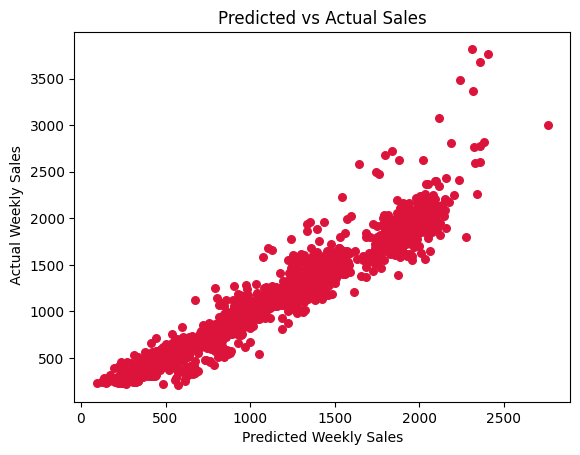

In [393]:
predictors=[col for col in data_imputed.columns if col not in ['Date','Weekly_Sales']]
X=data_imputed[predictors]
y=data_imputed.Weekly_Sales.values 

Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.33)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
r2=mlr.score(X_test, y_test)
print(mlr.score(X_test, y_test))
print(mlr.score(X_train, y_train))
adj_r2 = 1 - (len(y)-1)/(len(y)-X.shape[1]-1)*(1-r2)
print("Adjusted R^2",adj_r2)


# Perform 10-fold cross validation
scores = cross_val_score(mlr, X_train, y_train, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(mlr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, c='crimson', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

**Now let us look the same model without MarkDowns to check whether data with MarkDown or without MarkDown is good.** 

0.9375258528865502
0.9410510124829188
Cross-validated scores: [ 7.04103412e-01 -2.37290103e+13 -6.98308696e+13 -3.88349148e+11
 -2.17608132e+13 -2.44941058e+13 -1.44512082e+13 -2.62725545e+12
 -4.99452481e+12 -5.10364203e+13]
Mean Cross validation -21331255678674.453


Text(0.5, 1.0, 'Predicted vs Actual Sales')

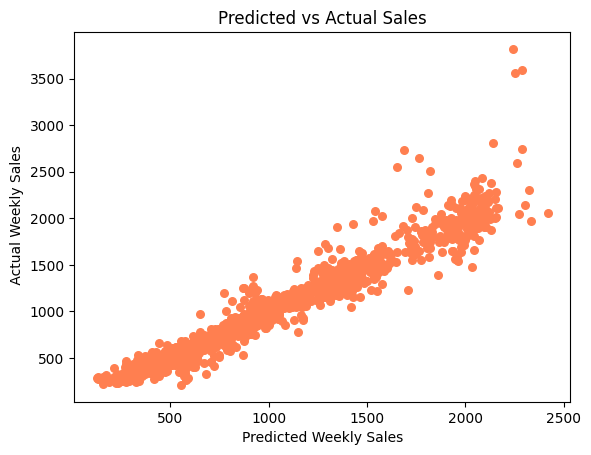

In [394]:
predictors=[col for col in data.columns if col not in ['Date','Weekly_Sales']]
predictors=[col for col in predictors if 'MarkDown' not in col]
X=data[predictors]
y=data.Weekly_Sales.values 
Xs = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))


# Perform 10-fold cross validation
scores = cross_val_score(lr, X, y, cv=10)
print ("Cross-validated scores:", scores)
print ("Mean Cross validation",scores.mean())



# Make cross validated predictions on the test sets
predictions = cross_val_predict(lr, X_test, y_test, cv=10)

plt.scatter(predictions, y_test, s=30, color = 'coral', zorder=10)
plt.xlabel('Predicted Weekly Sales')
plt.ylabel(' Actual Weekly Sales')
plt.title('Predicted vs Actual Sales')

#### From the Cross validation its clear that the one with Markdown values are better than they are dropped. 

So we will keep MarkDowns as of now and **assume** the KNN model have imputed the correct values. 
Now lets move on to real **Modeling** for the prediction of Weekly_sales

We have seen that normal running of Linear regression is a very bad idea. Even though it gives a high R2 value the cross validated score doesn't make any sense. Now its time to go on with **feature selection**


In [395]:
data=data_imputed.copy()

**We will divide our train and test datasets first and then deal with that seperately**

In [396]:
# Setting the offset to finalize the test data.
offset = timedelta(days=90)
split_date=data.Date.max()-offset

In [397]:
data_train=data[data.Date < split_date]
data_test=data[data.Date > split_date]

**Before we start lets shuffle the dataframe a bit because while we use crossvalidation for regressors it won't take a random sample as test and train, instead it takes section by section. Here my Dataframe have data for each store in order. So if we take section by section model might not have enough data to learn about certain stores and which intern will give terrible answers**

In [398]:
data_train = data_train.reindex(np.random.permutation(data_imputed.index))## Identify outliers

In [399]:
data_train.columns

Index(['Date', 'Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'MarkdownsSum', 'Type_A', 'Type_B',
       'Store_2', 'Store_3', 'Store_4', 'Store_5', 'Store_6', 'Store_7',
       'Store_8', 'Store_9', 'Store_10', 'Store_11', 'Store_12', 'Store_13',
       'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18', 'Store_19',
       'Store_20', 'Store_21', 'Store_22', 'Store_23', 'Store_24', 'Store_25',
       'Store_26', 'Store_27', 'Store_28', 'Store_29', 'Store_30', 'Store_31',
       'Store_32', 'Store_33', 'Store_34', 'Store_35', 'Store_36', 'Store_37',
       'Store_38', 'Store_39', 'Store_40', 'Store_41', 'Store_42', 'Store_43',
       'Store_44', 'Store_45', 'Month_Apr', 'Month_Aug', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_Jun', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'Year_2011', 'Year_2012',
       'Week_1.0', 'We

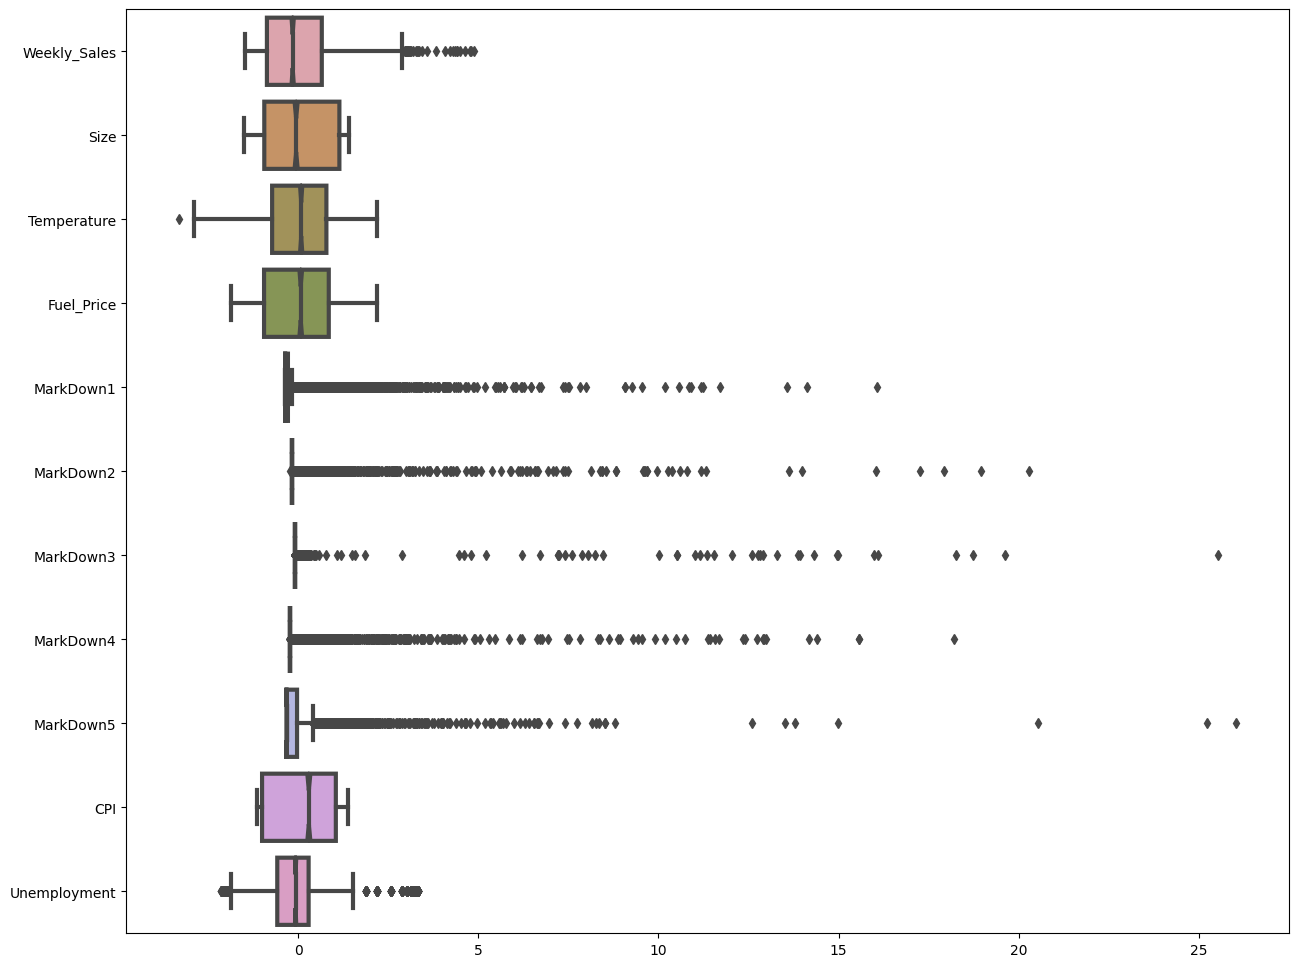

In [400]:
data_box=data_train.iloc[:, 1:12]
data_norm = (data_box - data_box.mean()) / data_box.std()

fig = plt.figure(figsize=(15, 12))
ax = fig.gca()

ax = sns.boxplot(data=data_norm, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax)
plt.show()

**There are quite a lot of outliers in MarkDown, But Lets first deal the outliers in weekly sales data because we might just drop MarkDowns Later because the percentage of missing values are really high in MarkDowns**

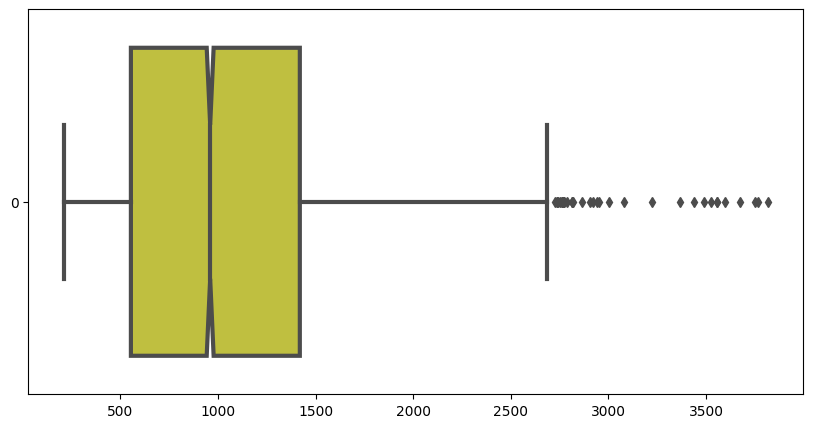

In [401]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()

ax = sns.boxplot(data_train.Weekly_Sales, orient='h', fliersize=5, 
                 linewidth=3, notch=True, saturation=0.5, ax=ax, color = 'yellow')
plt.show()

In [402]:
# Lets consider 3,000,000 as upper limit 
data_train[data_train.Weekly_Sales>3000].shape

(14, 77)

In [403]:
# there is only 14 outliers. Lets drop it and proceed.
data_train=data_train[data_train.Weekly_Sales<3000]

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Improve and Evaluate Model</p>


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Feature Selection </p>


We have seen the models are giving a terrible crossvalidation score. So lets tune our model. for that first we should figure out what all should we use as our features. For this a feature selection would be the best thing. So lets use Lasso Feature Selection and see how our model works with that.

In [404]:
predictors=[col for col in data.columns if col not in ['Weekly_Sales','Sqrt_Sales','lnSales','Date']] # Date

predictors=[col for col in predictors if 'Month' not in col]
predictors=[col for col in predictors if 'Week' not in col]
predictors=[col for col in predictors if 'Year' not in col]


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Test-Train Split such that Test data is last 90 days data (future 3 months prediction) </p>

In [405]:
X_train = data_train[predictors]
y_train = data_train.Weekly_Sales.values

X_test = data_test[predictors]
y_test = data_test.Weekly_Sales.values

In [406]:
X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> LGBM Regressor </p>

**LightGBM is a relatively new algorithm. It is a gradient boosting framework that uses tree based learning algorithm.**

*Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise.*

It chooses the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm. Light GBM is prefixed as ‘Light’ because of its high speed. 

**Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development.**

In [407]:
lgbm_features = lgb.LGBMRegressor() 

In [408]:
bool_columns = X_train.select_dtypes(include=["object"]).columns

X_train[bool_columns] = X_train[bool_columns].astype(bool)

In [409]:
lgbm_features.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2681
[LightGBM] [Info] Number of data points in the train set: 5836, number of used features: 58
[LightGBM] [Info] Start training from score 1042.925827


LGBMRegressor()

In [410]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

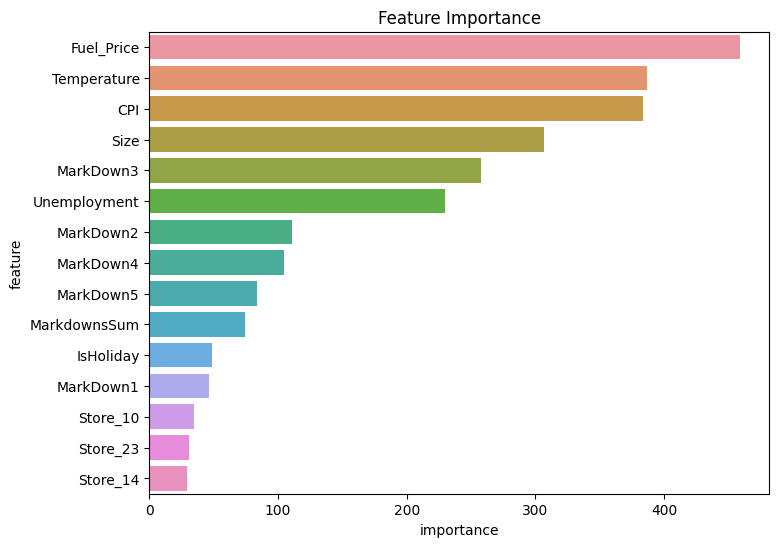

In [411]:
plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');

#### Clearly we have the top features listed above.

**Top five :**
    
    Fuel_Price
    CPI
    Markdown3
    Temperature
    Size
    

## Note :
    
 1. sklearn’s algorithm cheat sheet suggests to try Lasso, ElasticNet, or Ridge when our data-set is smaller than 100k rows. Else, try GDRegressor.

 2. Lasso and ElasticNet tend to give sparse weights (most zeros), because the l1 regularization cares equally about driving down big weights to small weights, or driving small weights to zeros. If you have a lot of predictors (features), and you suspect that not all of them are that important, Lasso and ElasticNet may be really good idea to start with.

***As both the above conditions satisfy, we should go with Lasso regressor and see the performance.***

*If it's not good enough we can always switch back to LGBM/XGB etc.*

#### LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 

*The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.*

**So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.**

Here, we want to evaluate the best model complexity (order of polynomial degree) for our LASSO regression model. Do we need linear regression with 7th degree order terms to reach the best accuracy, or is 2nd degree enough? Let's see.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Lasso Feature Selection </p>

Test- Train Split such that Test data is last 90 days data (Like a furture 3 months prediction)

#### LASSO is a regression analysis method that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 

*The basic idea is to penalize the model coefficients such that they don’t grow too big and overfit the data. Using LASSO regression, we are essentially eliminating the higher-order terms in the more complex models.*

**So, LASSO regression is similar to Linear Regression, but with a penalization coefficient at the end of the formula, eliminating the least important terms.**

Here, we want to evaluate the best model complexity (order of polynomial degree) for our LASSO regression model. Do we need linear regression with 7th degree order terms to reach the best accuracy, or is 2nd degree enough? Let's see.

In [412]:
lasso_cv = LassoCV(n_alphas=1000,max_iter=2000, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


LassoCV(cv=10, max_iter=2000, n_alphas=1000, verbose=1)

In [413]:
# Put the features and coefs into a dataframe
# sort by magnitude
lasso_feat = pd.DataFrame(dict(feature=X_train.columns, coef=lasso_cv.coef_, abscoef=np.abs(lasso_cv.coef_)))
lasso_feat.sort_values('abscoef', inplace=True, ascending=False)
# main_features
lasso_feat[lasso_feat.coef != 0.]

feature        coef     abscoef
0           Size  326.275137  326.275137
12        Type_A  204.075497  204.075497
22      Store_10  136.595911  136.595911
20       Store_8  -96.860883   96.860883
45      Store_33  -93.631335   93.631335
52      Store_40  -91.864990   91.864990
44      Store_32  -88.870329   88.870329
48      Store_36  -79.732063   79.732063
46      Store_34  -78.911819   78.911819
38      Store_26  -76.075241   76.075241
53      Store_41  -75.058094   75.058094
21       Store_9  -67.352226   67.352226
23      Store_11  -66.402802   66.402802
35      Store_23   60.673881   60.673881
36      Store_24  -60.132474   60.132474
43      Store_31  -56.751423   56.751423
40      Store_28  -50.790635   50.790635
31      Store_19  -47.978460   47.978460
27      Store_15  -47.411120   47.411120
32      Store_20   42.276246   42.276246
37      Store_25  -41.612235   41.612235
33      Store_21  -41.217355   41.217355
26      Store_14   40.737605   40.737605
5      MarkDown3   39.668317   39.668317
51      Store_39  -37.772412   37.772412
9   Unemployment  -36.092739   36.092739
56      Store_44  -35.396137   35.396137
16       Store_4   34.265238   34.265238
24      Store_12   33.610477   33.610477
18       Store_6  -33.013985   33.013985
41      Store_29  -32.077198   32.077198
17       Store_5  -30.236393   30.236393
30      Store_18   24.085962   24.085962
55      Store_43   21.745800   21.745800
28      Store_16  -18.861524   18.861524
14       Store_2   18.629979   18.629979
57      Store_45  -17.482679   17.482679
15       Store_3  -16.915124   16.915124
19       Store_7  -16.112038   16.112038
7      MarkDown5   14.831142   14.831142
42      Store_30  -14.356728   14.356728
34      Store_22   14.295609   14.295609
25      Store_13   13.068249   13.068249
4      MarkDown2  -12.466153   12.466153
47      Store_35   12.403082   12.403082
10     IsHoliday   11.858135   11.858135
2     Fuel_Price  -11.113382   11.113382
1    Temperature   -9.177152    9.177152
54      Store_42    8.788739    8.788739
29      Store_17    7.932197    7.932197
6      MarkDown4   -6.404421    6.404421
3      MarkDown1    5.524293    5.524293
50      Store_38   -2.461644    2.461644
8            CPI    1.478180    1.478180

In [414]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm_features.feature_importances_
}).sort_values('importance', ascending=False)

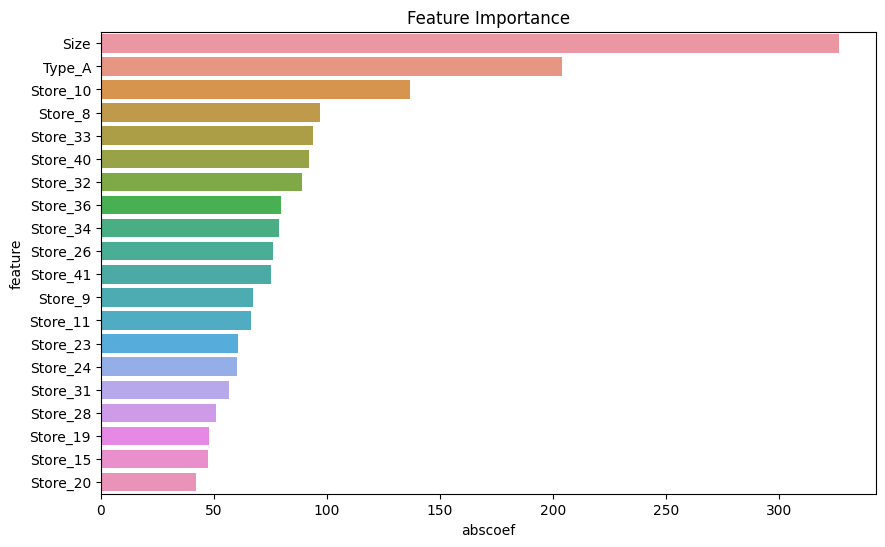

In [415]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lasso_feat.head(20), x='abscoef', y='feature');

**The list of features that are seleted and their magnitude of effect on weekly sales can be seen above (remember the target is scaled down)**

*We will set the predictors that we got from Lasso as our actual predictors and use in further models*

In [416]:
actual_predictors=lasso_feat[lasso_feat.coef != 0.].feature.values

In [417]:
# Lets see the best alpha score
lasso_cv.alpha_

#best alpha value is 0.45384197291954748 which could be used later to run model

0.4538419729195478

In [418]:
# We will assign the best alpha score and according to that we will train and test our model
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=0.4538419729195478)

In [419]:
lasso_scores = cross_val_score(best_lasso, X_train_s, y_train, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))

[0.9127855  0.95714654 0.93024025 0.93910105 0.93465499 0.94497481
 0.92512313 0.94257633 0.91973253 0.93413824]
0.9340473357452869


#### Thats great. getting a cross validated score of .933 is good. Now lets use this to predict our last 90 days data which the model don't know about. So if this works well in this test data give a good score and residual is small or comparable to train data we can assume its not overfitting

In [420]:
lasso_yhat=best_lasso.predict(X_test_s)
lasso_score=best_lasso.score(X_test_s, y_test)
print("R2: ",lasso_score)
lasso_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-lasso_score)
print("Adjusted R2: ",lasso_adj_r2)

R2:  0.9579607684542987
Adjusted R2:  0.9533252638351909


In [421]:
# converting the residuals into the actual dimenssion

train_resids = y_train*1000 - best_lasso.predict(X_train_s)*1000
test_resids = y_test*1000 - lasso_yhat*1000
lasso_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",lasso_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())
# The Residual looks quite big. But this can be because our base values ( Weekly Sales) are quite big 
# and in terms of millions

Train Residual 495663375.29885685
Test Residual 40971269.0645984
Residual ratio of Test to Train 0.08265946427834223


The residuals seems to be in same ratio,Train dataset have a higher ratio because its compartively bigger in size. 


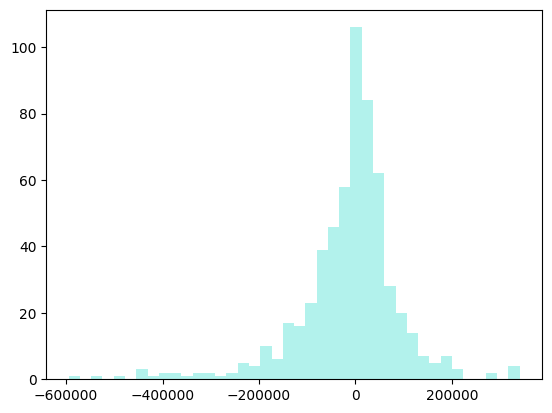

In [422]:
sns.distplot(test_resids, kde=False, bins=40, color = 'turquoise')
plt.show()

# The residuals looks ok and almost like a normal distribution

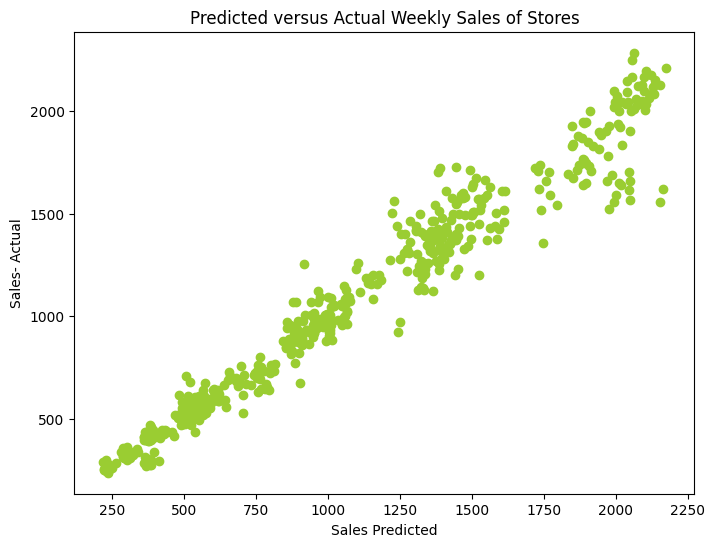

In [423]:
fig = plt.subplots(figsize=(8,6))
plt.scatter(lasso_yhat,y_test, c='yellowgreen')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
#plt.savefig('./images/Actual_vs_Predicted_Sales.png')
plt.show()

Lasso Model works well giving me a good adjusted R2 and low residual. The residual is also form a normal distribution whcih shows the model is doing not much wierd things. **The actual vs Predicted Sales looks promising** 


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Setting the predictors from Lasso and Train Test split for further use </p>

We will set my predictors to the ones that are selected from Lasso and will use this predictors and Train Test split for further use in all my models.

In [424]:
X_train = X_train[actual_predictors]
X_test = X_test[actual_predictors]

X_train_s=ss.fit_transform(X_train)
X_test_s=ss.fit_transform(X_test)




# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Final Model selection & Implementation</p>


We have already implemented Lasso Regressor and would be looking through and implementing different model of regressors in this part. This is more or a trail and error method with the know models that could do better in Regressions



#### Decision Trees are likely to overfit and result in over learning. 
So we will go for Random Forest Regressor which is a ensemble method of decision tree and check how it works.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Random Forest Regressor </p>

In [425]:
rfr=RandomForestRegressor(n_estimators=100, max_depth=None, max_features='auto')

In [426]:
# Fit and crossvalidate on train data
rfr.fit(X_train_s, y_train)
rfr_scores = cross_val_score(rfr, X_train_s, y_train, cv=10)
np.mean(rfr_scores)

0.951157334839728

In [427]:
rfr_yhat = rfr.predict(X_test_s)
rfr_score=rfr.score(X_test_s, y_test)

print("R2: ",rfr_score)
rfr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-rfr_score)
print("Adjusted R2: ",rfr_adj_r2)

R2:  0.8204206627605766
Adjusted R2:  0.8021239000984466


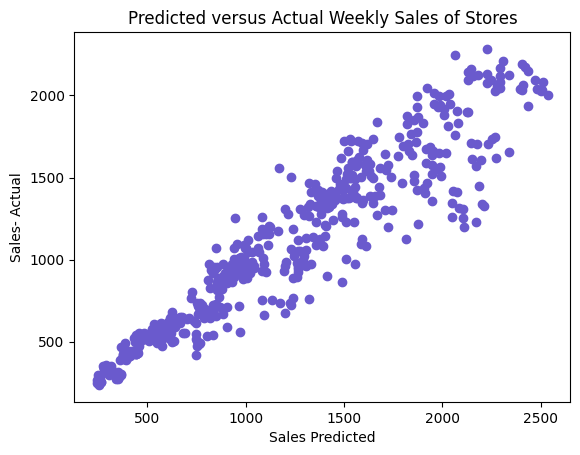

In [428]:
plt.scatter(rfr_yhat, y_test, color='slateblue')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')
plt.show()

In [429]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - rfr_yhat*1000
rfr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",rfr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 148058027.931
Test Residual 83049178.38500002
Residual ratio of Test to Train 0.5609231700945235


The cross validated score on train data seems to be very good but test score is not that upto mark which says this might not be the best model. Even when we look into residuals its big compared to the size of train data. So we will move on to another model and see how it would be.


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> GradientBoostingRegressor</p>

In [430]:
gb = GradientBoostingRegressor(n_estimators=100,max_depth=10,learning_rate=0.1)

In [431]:
gb.fit(X_train_s, y_train)
gb_scores = cross_val_score(gb, X_train_s, y_train, cv=6)
np.mean(gb_scores)

0.9534801245130139

In [432]:
gb_yhat=gb.predict(X_test_s)
gb_score=gb.score(X_test_s,y_test)

print("R2: ",gb_score)
gb_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-gb_score)
print("Adjusted R2: ",gb_adj_r2)

R2:  0.8221739963852062
Adjusted R2:  0.8040558752621895


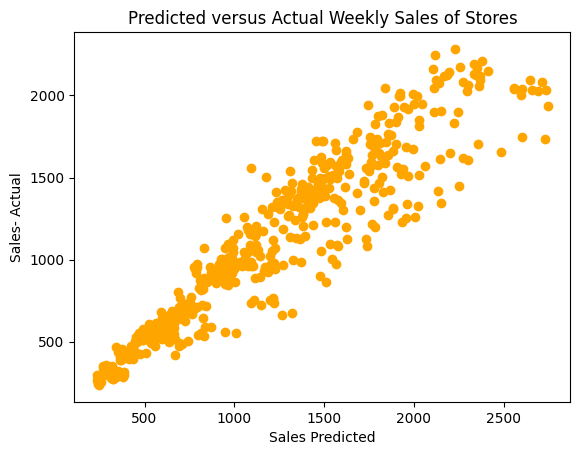

In [433]:
plt.scatter(gb_yhat, y_test, c='orange')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [434]:
train_resids = y_train*1000 - gb.predict(X_train_s)*1000
test_resids = y_test*1000 - gb_yhat*1000
gb_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual",np.abs(train_resids).sum())
print("Test Residual",gb_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 82812821.71263857
Test Residual 80054049.08591902
Residual ratio of Test to Train 0.9666866486412874


Here we can see the model is learning a lot from train data and gives a cross validated score of .95 where as in the test data the score is .79 which is too low compared to train data. Its not a good sign.
I will check the residuals and here the test residual is higher than train even though the train dataset is much bigger.

**This again is a clear case of over fitting and we wont use this model further.**


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Support Vector Regression</p>

In [435]:
svr=SVR(C=50000.0, max_iter=500)

svr.fit(X_train_s, y_train)

SVR(C=50000.0, max_iter=500)

In [436]:
svr_scores = cross_val_score(svr, X_train_s, y_train, cv=10)
np.mean(svr_scores)

0.5546741361548403

In [437]:
svr_yhat=svr.predict(X_test_s)
svr_score=svr.score(X_test_s,y_test)
print("R2: ",svr_score)
svr_adj_r2 = 1 - (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)*(1-svr_score)
print("Adjusted R2: ",svr_adj_r2)

R2:  -0.18764811518502422
Adjusted R2:  -0.3086537722038758


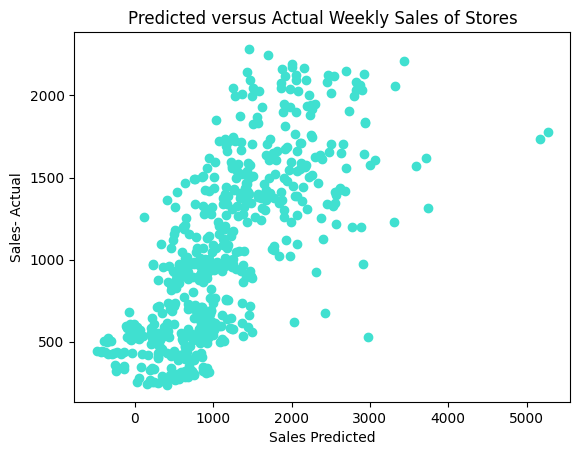

In [438]:
plt.scatter(svr_yhat, y_test, c='turquoise')
plt.xlabel('Sales Predicted')
plt.ylabel('Sales- Actual')
plt.title('Predicted versus Actual Weekly Sales of Stores')

plt.show()

In [439]:
train_resids = y_train*1000 - rfr.predict(X_train_s)*1000
test_resids = y_test*1000 - svr_yhat*1000
svr_residue=np.abs(test_resids).sum()
# Let me look at the actual Residuals.
print("Train Residual", np.abs(train_resids).sum())
print("Test Residual",svr_residue)
print("Residual ratio of Test to Train",np.abs(test_resids).sum()/np.abs(train_resids).sum())

Train Residual 148058027.931
Test Residual 244998828.6368041
Residual ratio of Test to Train 1.6547486959030804


**This looks great!** The cross validation score and score on test data are almost same even though its not a very high percentage. Even the residuals are small. This tells atleast there is no much overfittig.

#### So out of all models the best comes with Lasso regression

In [440]:
Residual_graph=pd.DataFrame()
Residual_graph["Store"]=range(1,46)
Residual_graph['actual_y']=0
Residual_graph['predicted_lasso_y']=0

count=0
for x in y_test:
    count+=1
    Residual_graph['actual_y'][count%45]+=x

count=0
for x in lasso_yhat:
    count+=1
    Residual_graph['predicted_lasso_y'][count%45]+=x  

Residual_graph["actual_y"]=Residual_graph["actual_y"]/13
Residual_graph["predicted_lasso_y"]=Residual_graph["predicted_lasso_y"]/13

Residual_graph["Residual_lasso"]=np.abs(Residual_graph["actual_y"] - Residual_graph["predicted_lasso_y"])
Residual_graph["Residual_lasso_percentage"]=(Residual_graph["Residual_lasso"]/Residual_graph["actual_y"])*100

In [441]:
# Setting the size of bubble according to the percentage change in prediction
s=Residual_graph.Residual_lasso_percentage.values
s=s*100

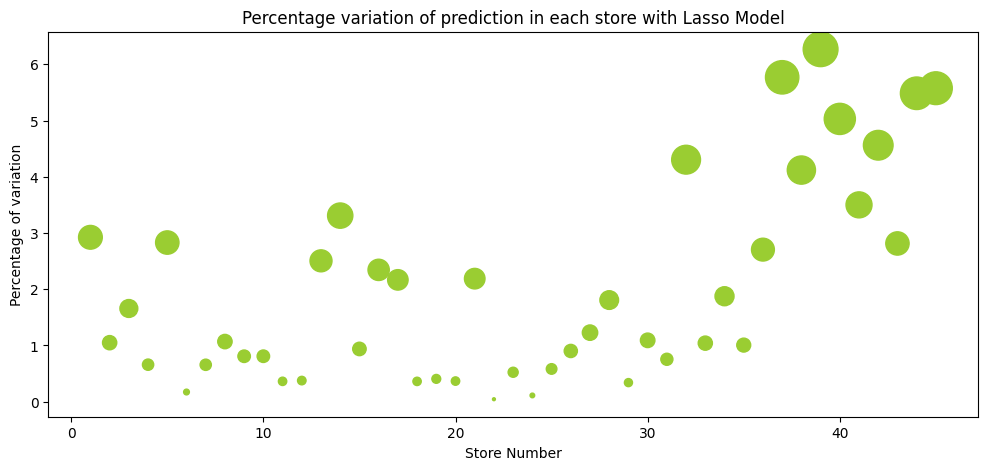

In [442]:
fig = plt.subplots(figsize=(12,5))
plt.scatter(Residual_graph.Store, Residual_graph.Residual_lasso_percentage, s=s, color = 'yellowgreen')
plt.xlabel('Store Number')
plt.ylabel('Percentage of variation')
plt.title('Percentage variation of prediction in each store with Lasso Model')
#plt.savefig('./images/percentage_prediction_variation.png')
plt.show()

#### This plot shows the variation of prediction or the percentage residual change for each store.

Here the bigger the bubble is the higher the variation in prediction. So we can see that there are **around 4 stores which have more than 5% variation in prediction.**

**The smaller the bubble the better it is** since that shows how predictions are close to actual values. This can be used to futher tune our model because some other model might be doing good with the store which is doing bad in this model.


In [443]:
# Create a dataframe to compare different models
Score=pd.DataFrame()
Score["Model_Name"]=('Lasso','RandomForest','GradientBoosting','SupportVector')
Score["Test_Score"]=(lasso_score,rfr_score,gb_score,svr_score)
Score["Adj_R2"]=(lasso_adj_r2,rfr_adj_r2,gb_adj_r2,svr_adj_r2)
Score["Test_Residual"]=(lasso_residue,rfr_residue,gb_residue,svr_residue)


# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">Insights & Conclusion</p>

<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Interpret findings and relate to goals/criteria</p>


 - From the modeling we have found **Lasso method works the best by itself with an accuracy of .93.**

 - The **rain forest regressor and SVR also works good**. We have plotted a percentage residual change with bubbles to check how good is the prediction for each store. 
 
 - This could be a good method to look into each store and see which stores are doing good with this model and which are not. 
 
 - Similarly we can find model that works better for that particular store and make an ensemble model with prediction power for each store assigned to each model.

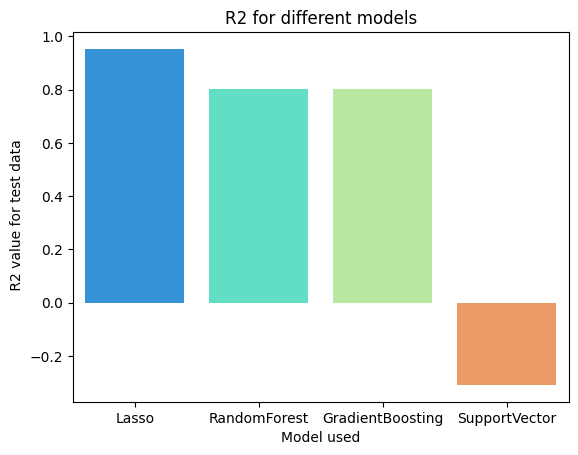

In [444]:
# Checking how the Type of the store have effect on the sales.
sns.barplot(x="Model_Name", y="Adj_R2", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' R2 value for test data')
plt.title('R2 for different models')
#plt.savefig('./images/R2_for_different_models.png')
plt.show()


**Lasso Regressor gives the best prediction and outperforms all other models as indicated by the R2 values.**

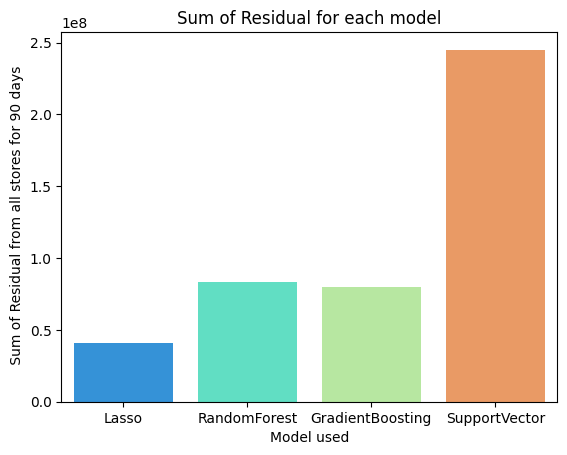

In [445]:
sns.barplot(x="Model_Name", y="Test_Residual", data=Score,orient='v', palette='rainbow')
plt.xlabel('Model used')
plt.ylabel(' Sum of Residual from all stores for 90 days')
plt.title('Sum of Residual for each model')
#plt.savefig('./images/Residual_for_different_models.png')
plt.show()

**Even the residual for Lasso model is way smaller compared to other models**

### Conclusion

*Finally, after building multiple models to predict the weekly sales of 45 stores, we got the best accuracy of around 94% of accuracy for 3 months(90 Days).*

Out of all the models, we select the **Lasso Regressor as our predictive Model since due to it's highest prediction accuracy  with the lowest residual(error).**



<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Recommendation and Benefits</p>

1. **Size of the store is the highest contributing predictor in the model out of all.**
2. **Each store has a unique prediction power**. They can be separately analyzed to get prediction for each individual store
3. The **Sales are very high during November and December and go down in January**. So its better to employee more staff as casual employee in November and December and encourage permanent staff to take leaves during January.
4. The predicted sales data can be used to analyse the sales pattern and accordingly **adjust the staff in the store.**
5. When we implement the project to department level it helps to plan the inventory and staff from a centralised station to every store, which will further help in **better planning and cost cutting** for **inventory management, supply chain management and human resource.**
6. The **low selling stores should look forward to increasing their size and capacity to store more items and consumer products.**
7. **Special discount coupons can be distributed during low selling periods to attract more customers**

8. Sales are likely to fluctuate during holidays. **Special offers can be given during festive season** accompanied with suitable marketing to keep the sales high during holidays as well


<p style="background-color:white;font-family:timesnewroman;color:lightseagreen;font-size:220%;border-radius:20px 60px;"> Next steps</p>

**The Next steps would be :-**

1. To check into the store that have poor prediction and check deep what makes those bad. 
2. To further improve the predictive model using the ensembling method to combine models and come with better model.
3. Take the data to Department level and to predict the Department level sales which would help to solve the inventory management issues and supply chain management.

![](https://businessfirstfamily.com/wp-content/uploads/2016/01/sales-forecasting-methods-graphs.jpg)

# <p style="background-color:white;font-family:newtimeroman;color:turquoise;font-size:150%;text-align:center;border-radius:20px 60px;">REFERENCES</p>

https://medium.datadriveninvestor.com/walmart-sales-data-analysis-sales-prediction-using-multiple-linear-regression-in-r-programming-adb14afd56fb

https://prezi.com/vpvakz73fjjp/walmart-sales-analysis/

https://www.kaggle.com/code/maxdiazbattan/wallmart-sales-eda-feat-eng-future-update

https://www.kaggle.com/code/avelinocaio/walmart-store-sales-forecasting

https://www.kaggle.com/code/yepp2411/walmart-prediction-1-eda-with-time-and-space

# <p style="background-color:coral;font-family:newtimeroman;color:white;font-size:150%;text-align:center;border-radius:20px 60px;">HAPPY FORECASTING!!!</p>